In [2]:
import pandas as pd, numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, r2_score, accuracy_score, f1_score, precision_score, recall_score, explained_variance_score, mean_absolute_error
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.evaluate import bootstrap
import copy
import warnings
from functools import reduce
warnings.filterwarnings("ignore")

sns.set()

In [4]:
dfs = dict(methylnet=dict(),other=dict())
dfs['methylnet']['pancancer'] = pd.read_csv('methylnet_corrections/pancancer/results.csv',index_col=0)#pd.read_csv('methylnet-pancancer_results.csv',index_col=0)
dfs['methylnet']['cell'] = pd.read_csv('methylnet-cell-type-results.csv',index_col=0)
dfs['methylnet']['age'] = pd.read_csv('methylnet_corrections/age/results.csv',index_col=0)#pd.read_csv('methylnet-age-results.csv',index_col=0)
dfs['other']['pancancer'] = pd.read_csv('svm-pancancer_sklearn_predictions.csv',index_col=0)
dfs['other']['cell'] = pd.read_csv('EpiDISH-cell-type-results.csv',index_col=0)
dfs['other']['age'] = pd.read_csv('cgage-age-results.csv',index_col=0)
one_hot_encoder = pickle.load(open('one_hot_encoder.p','rb'))
all_age_results = pickle.load(open('methylnet_corrections/age/results.p','rb'))#pickle.load(open('age_results.p','rb'))
all_cell_results = pickle.load(open('cell_results.p','rb'))
all_pancancer_results = pickle.load(open('methylnet_corrections/pancancer/results.p','rb'))#pickle.load(open('pancancer_results.p','rb'))



In [4]:
df_age=pd.concat((dfs['methylnet']['age'],dfs['other']['age']),axis=1)
df_age.head()

,Age_pred,Age_true,Hannum.Est,EpiTOC.Est,Horvath.Est
GSM2333902_9376538120_R06C01,51.333760,55.0,58.744945,0.062704,54.581645
GSM2333905_9370847096_R06C02,71.223620,74.0,74.166322,0.074922,68.815627
GSM2333914_7766148058_R01C01,57.552990,55.0,70.342944,0.125002,68.190866
GSM2333915_7766148025_R03C02,53.972880,65.0,63.511198,0.067484,57.955661
GSM2333921_7766148058_R03C01,22.626997,29.0,33.173665,0.084883,30.812725


Text(314.9970833333334, 0.5, 'True Age')

<Figure size 1800x1200 with 0 Axes>

<Figure size 4500x4500 with 0 Axes>

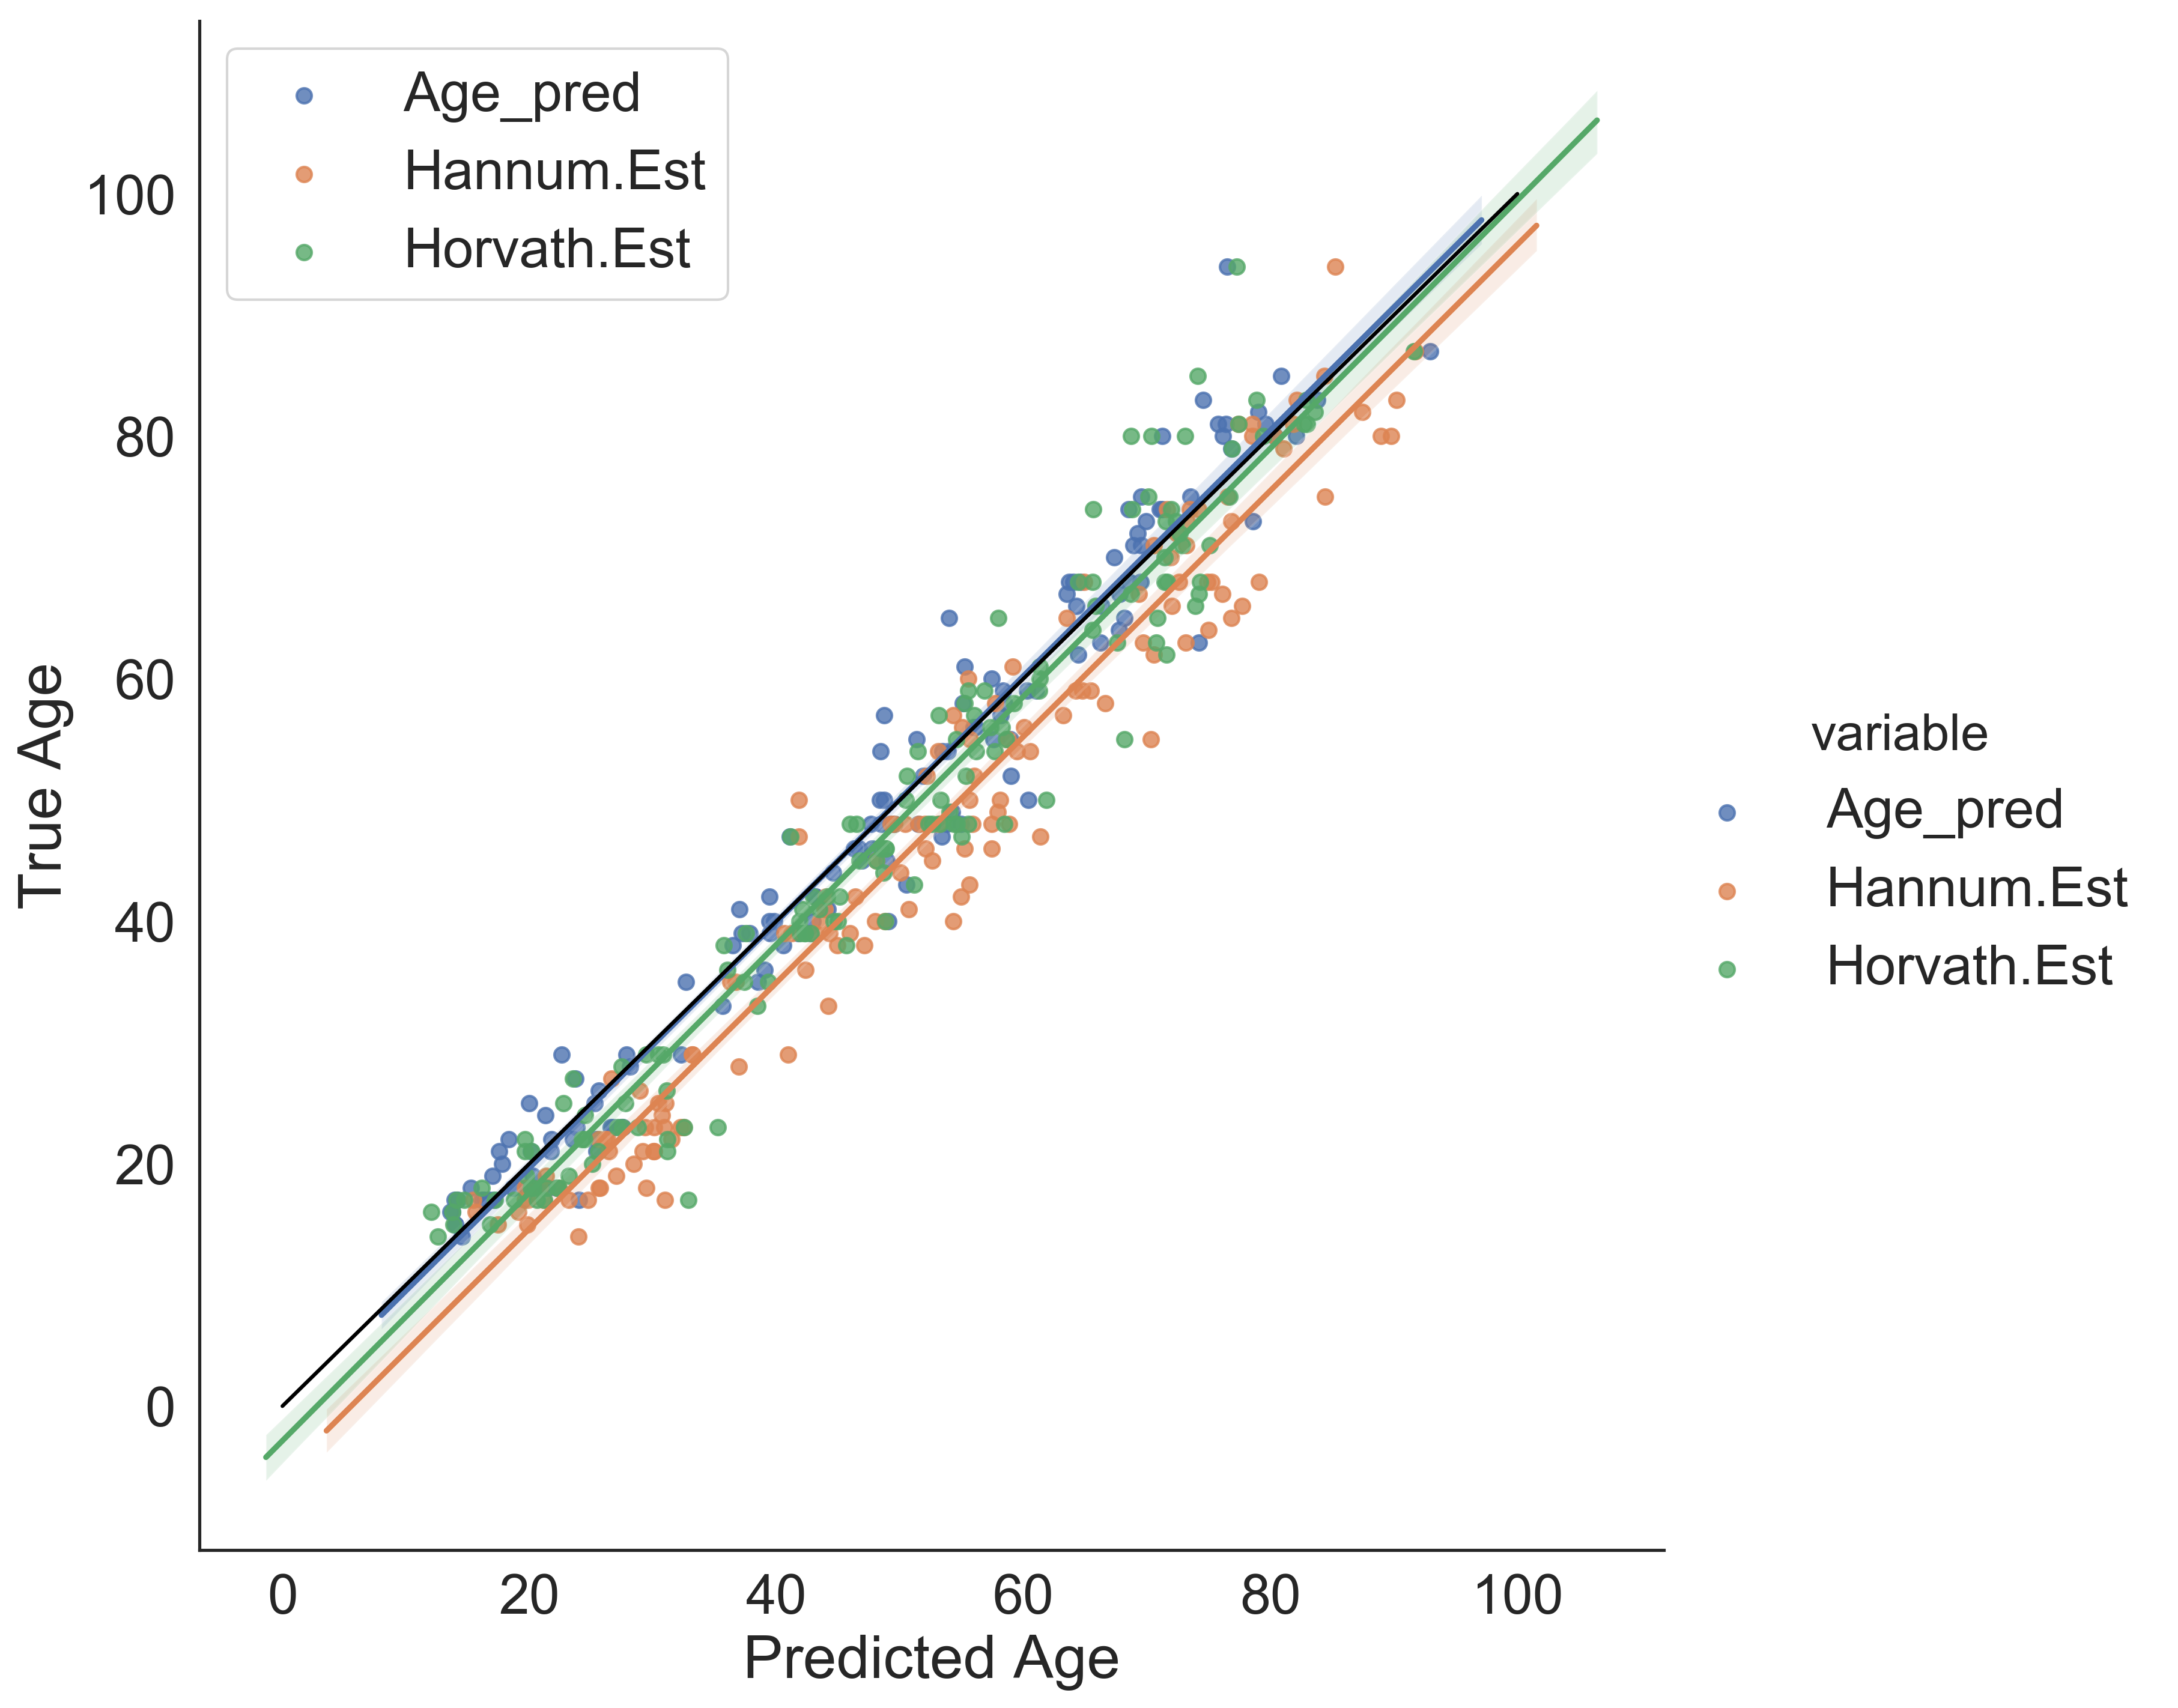

In [83]:
sns.set(style='white',font_scale=2.)
sns.despine()
plt.figure(figsize=(15,15))
sns.lmplot('value','Age_true',hue='variable',size=10,data=df_age.melt(id_vars=['Age_true'],value_vars=['Age_pred','Hannum.Est','Horvath.Est']))
#sns.lmplot('Age_pred','Age_true',data=df_age)
sns.lineplot(x=[0,100],y=[0,100],c='black')
plt.xlabel('Predicted Age')
plt.ylabel('True Age')
#plt.title('MethylNet Age Test Results')

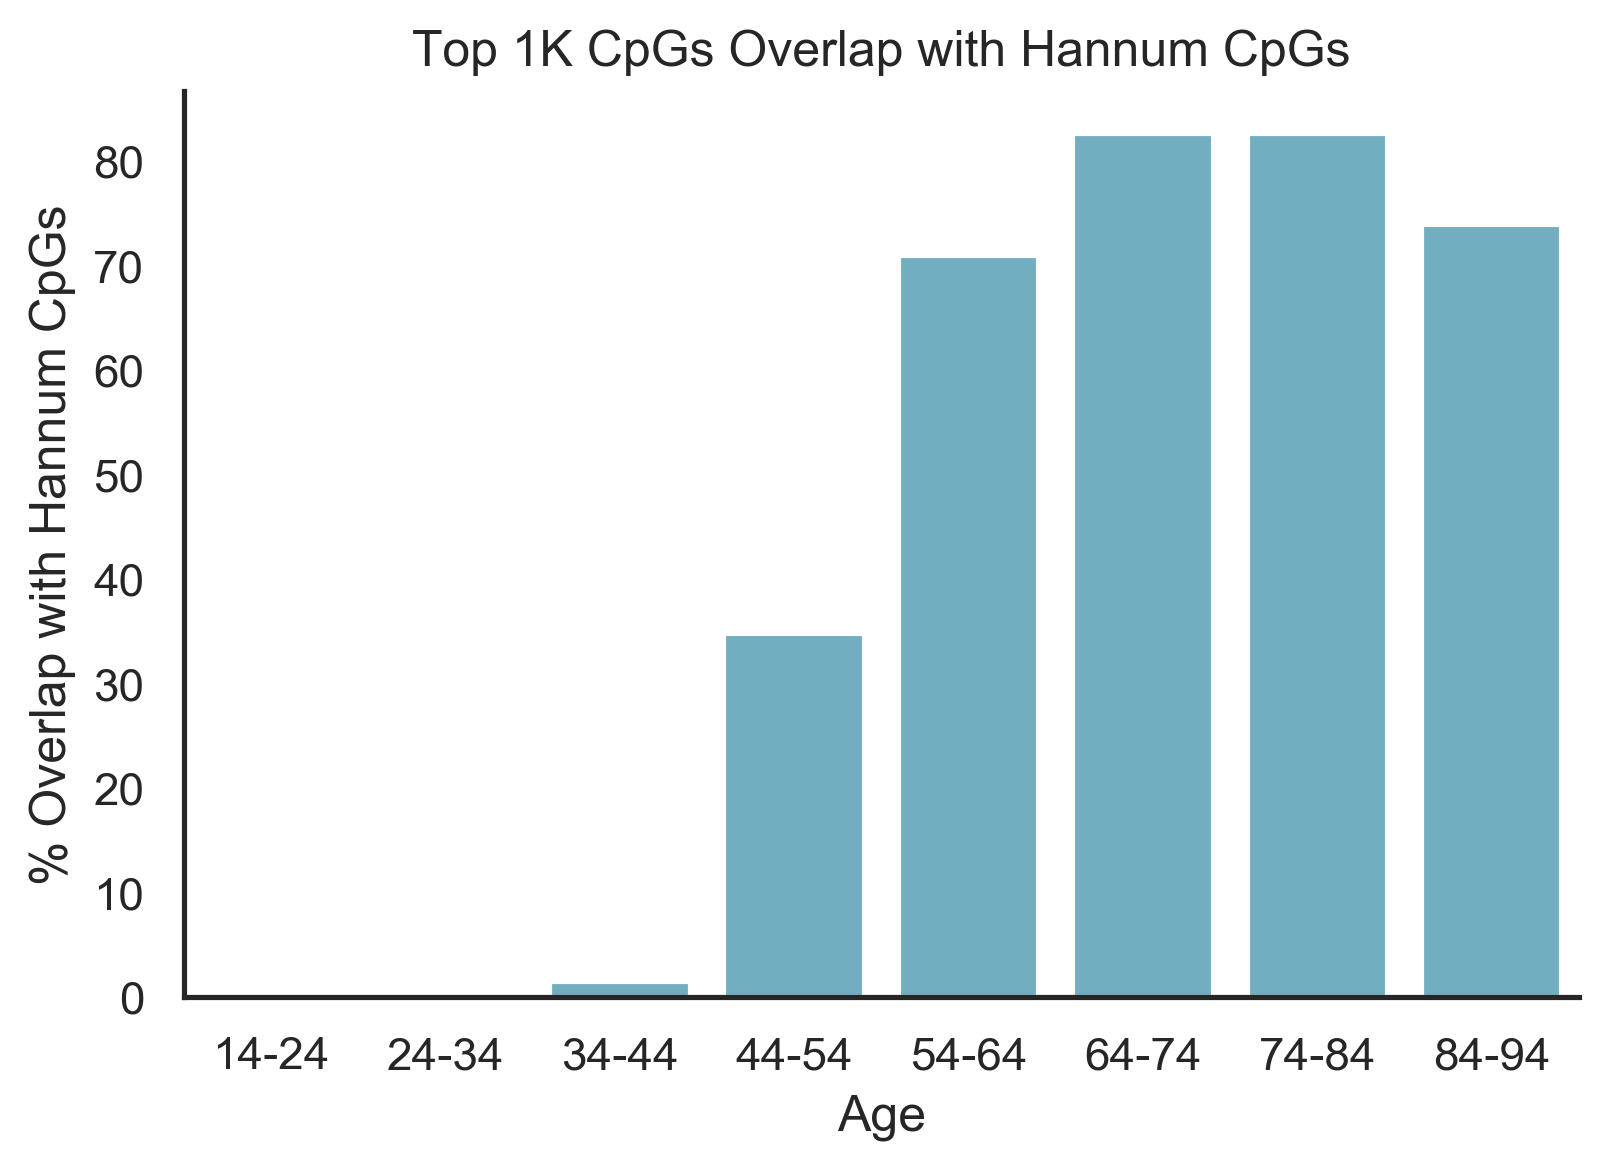

In [84]:
sns.set(style='white',font_scale=1.)


clock_cpg_results = list(map(lambda line: [w.replace('(','').replace(']','').replace(',','-').replace('%','') for w in line.split() if w[-1] in [']','%']],"""(14,24] top cpgs overlap with 0.0% of hannum cpgs
(24,34] top cpgs overlap with 0.0% of hannum cpgs
(34,44] top cpgs overlap with 1.45% of hannum cpgs
(44,54] top cpgs overlap with 34.78% of hannum cpgs
(54,64] top cpgs overlap with 71.01% of hannum cpgs
(64,74] top cpgs overlap with 82.61% of hannum cpgs
(74,84] top cpgs overlap with 82.61% of hannum cpgs
(84,94] top cpgs overlap with 73.91% of hannum cpgs""".splitlines()))
plt.figure()
df=pd.DataFrame(clock_cpg_results,columns=['Age','Percent Hannum CpGs'])
df.iloc[:,1]=df.iloc[:,1].astype(float)
sns.barplot('Age','Percent Hannum CpGs',data=df, color=sns.color_palette()[-1])
plt.ylabel('% Overlap with Hannum CpGs')
plt.title('Top 1K CpGs Overlap with Hannum CpGs')
sns.despine()

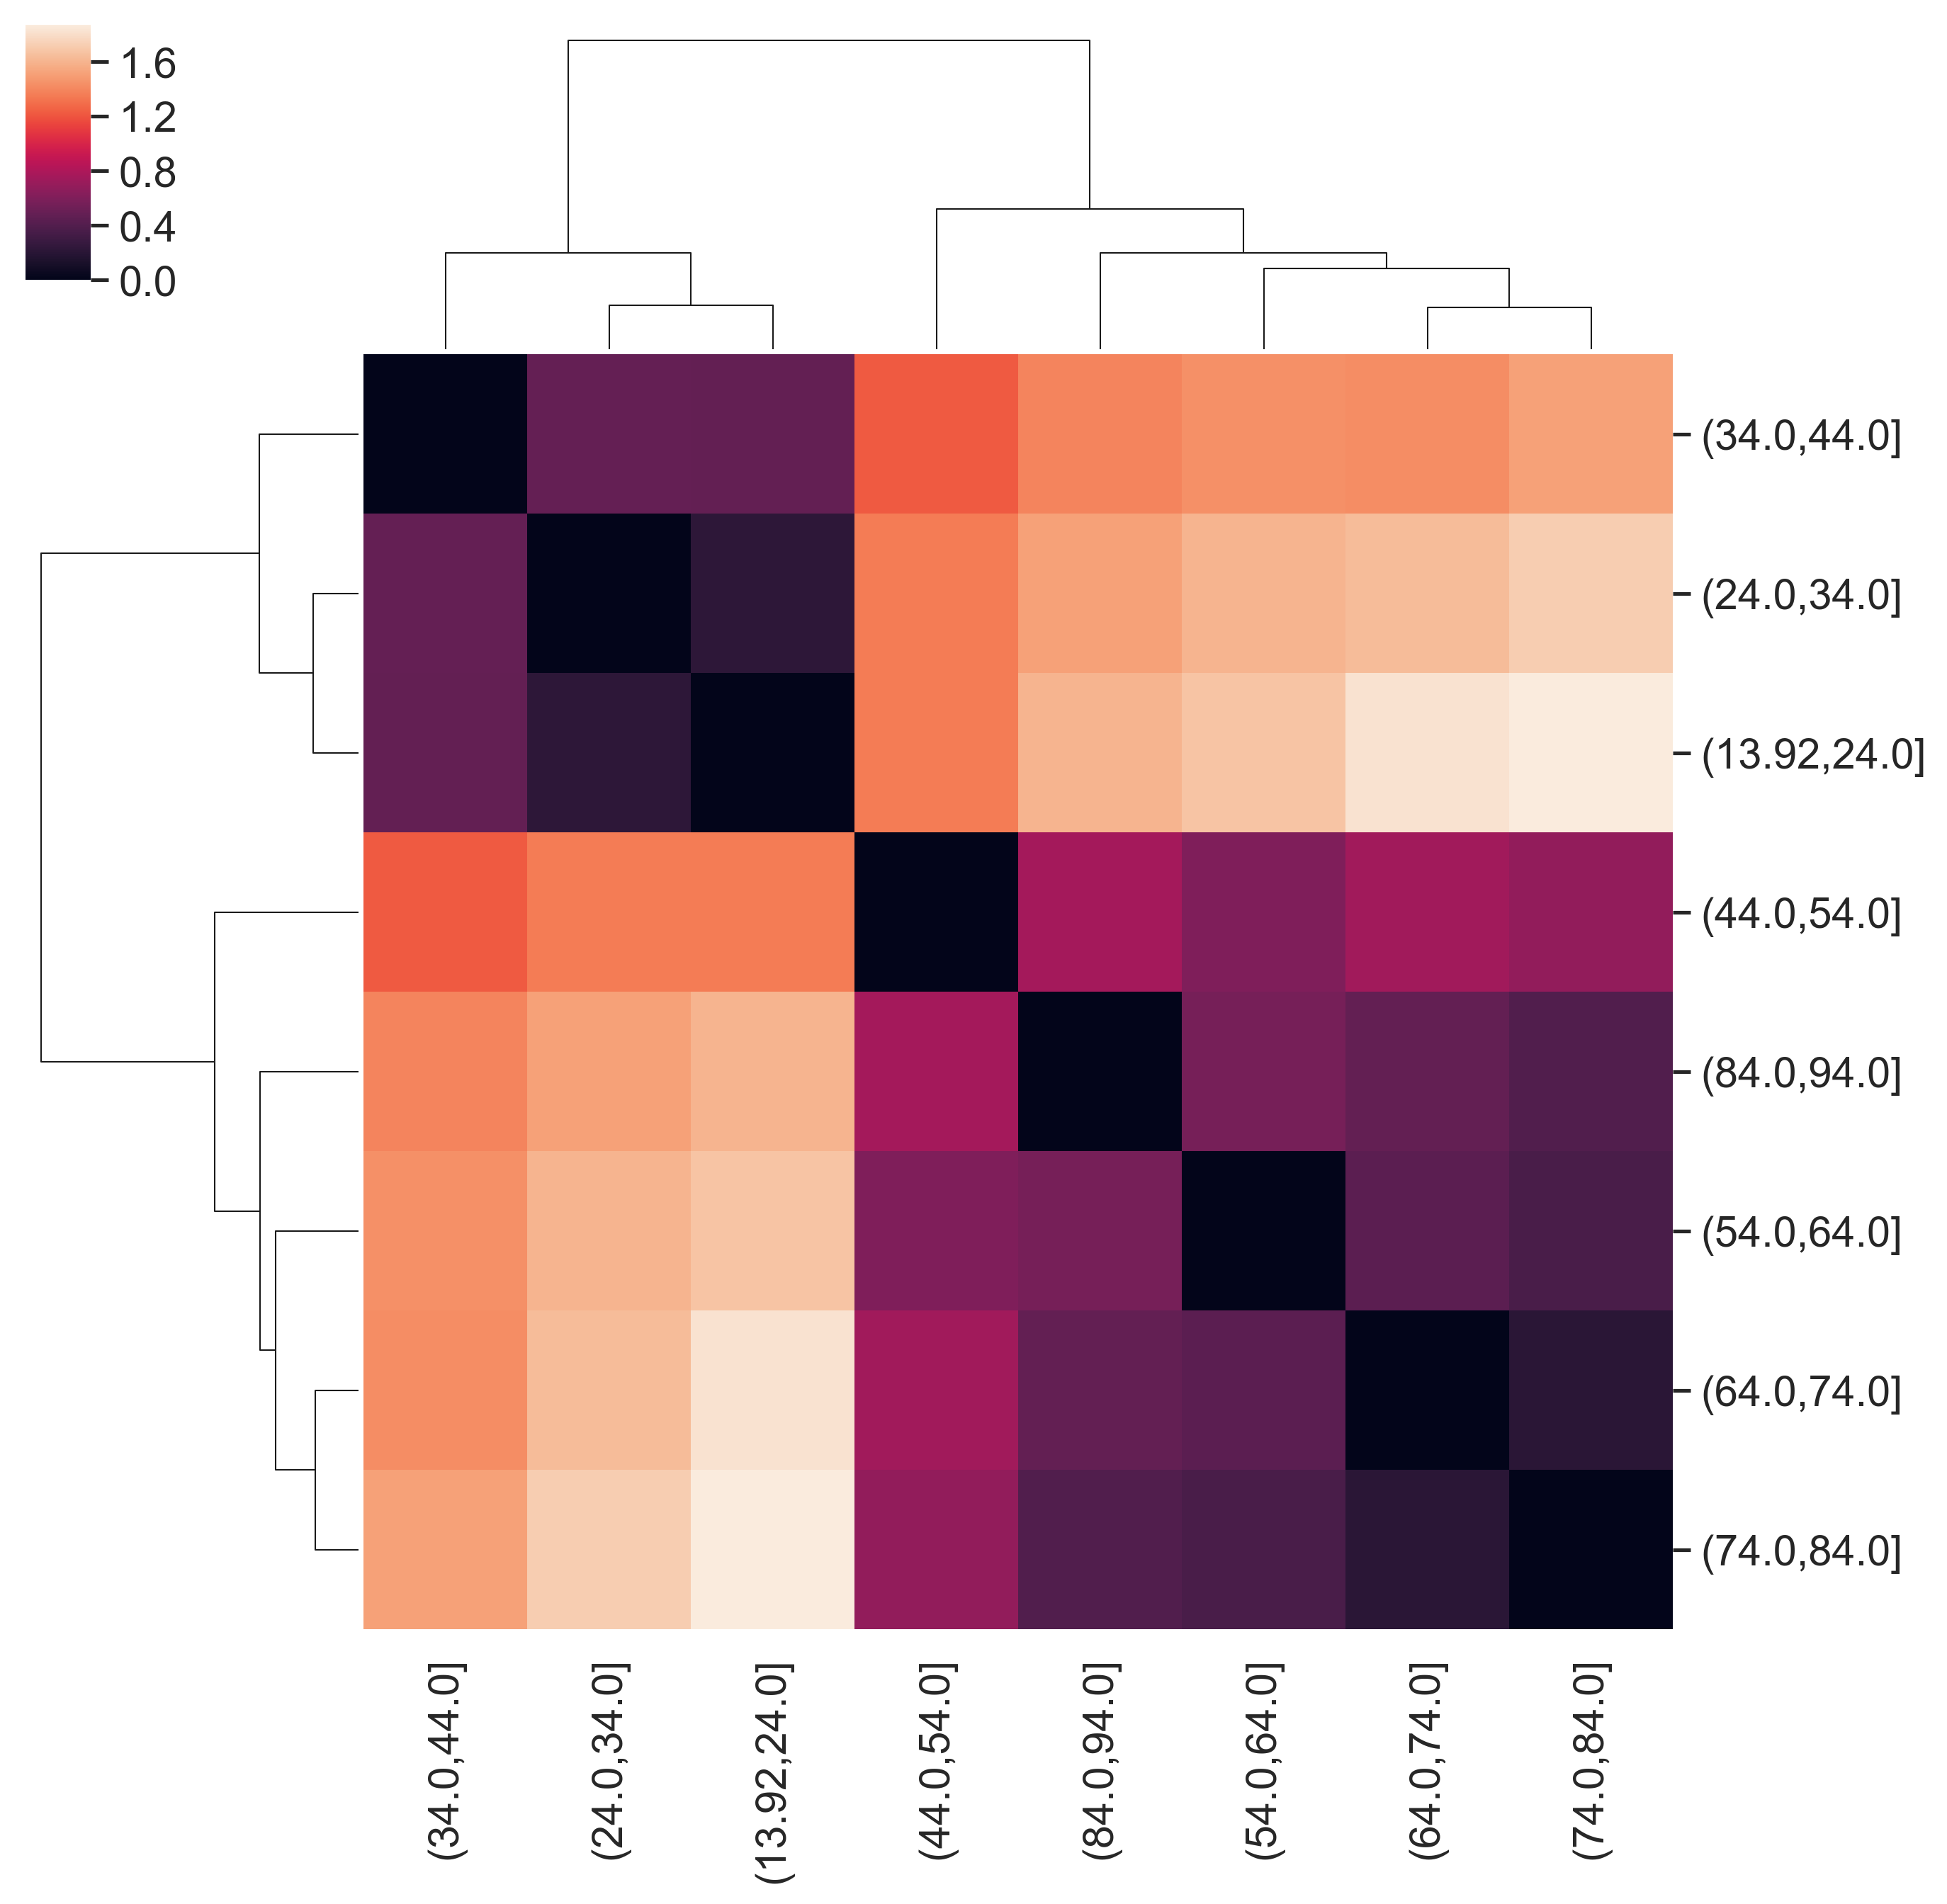

In [86]:
df_age_corr=pd.read_csv('methylnet_corrections/age/returned_shap_values_corr_dist.csv',index_col=0)
from scipy.cluster.hierarchy import linkage, fcluster
import scipy.spatial as sp
sns.set(font_scale=1.3)
linkage_method='average'
links=linkage(sp.distance.squareform(df_age_corr.values),method=linkage_method)
sns.clustermap(data=df_age_corr,row_linkage=links,col_linkage=links)

In [7]:
df_cell_corr.columns

NameError: name 'df_cell_corr' is not defined

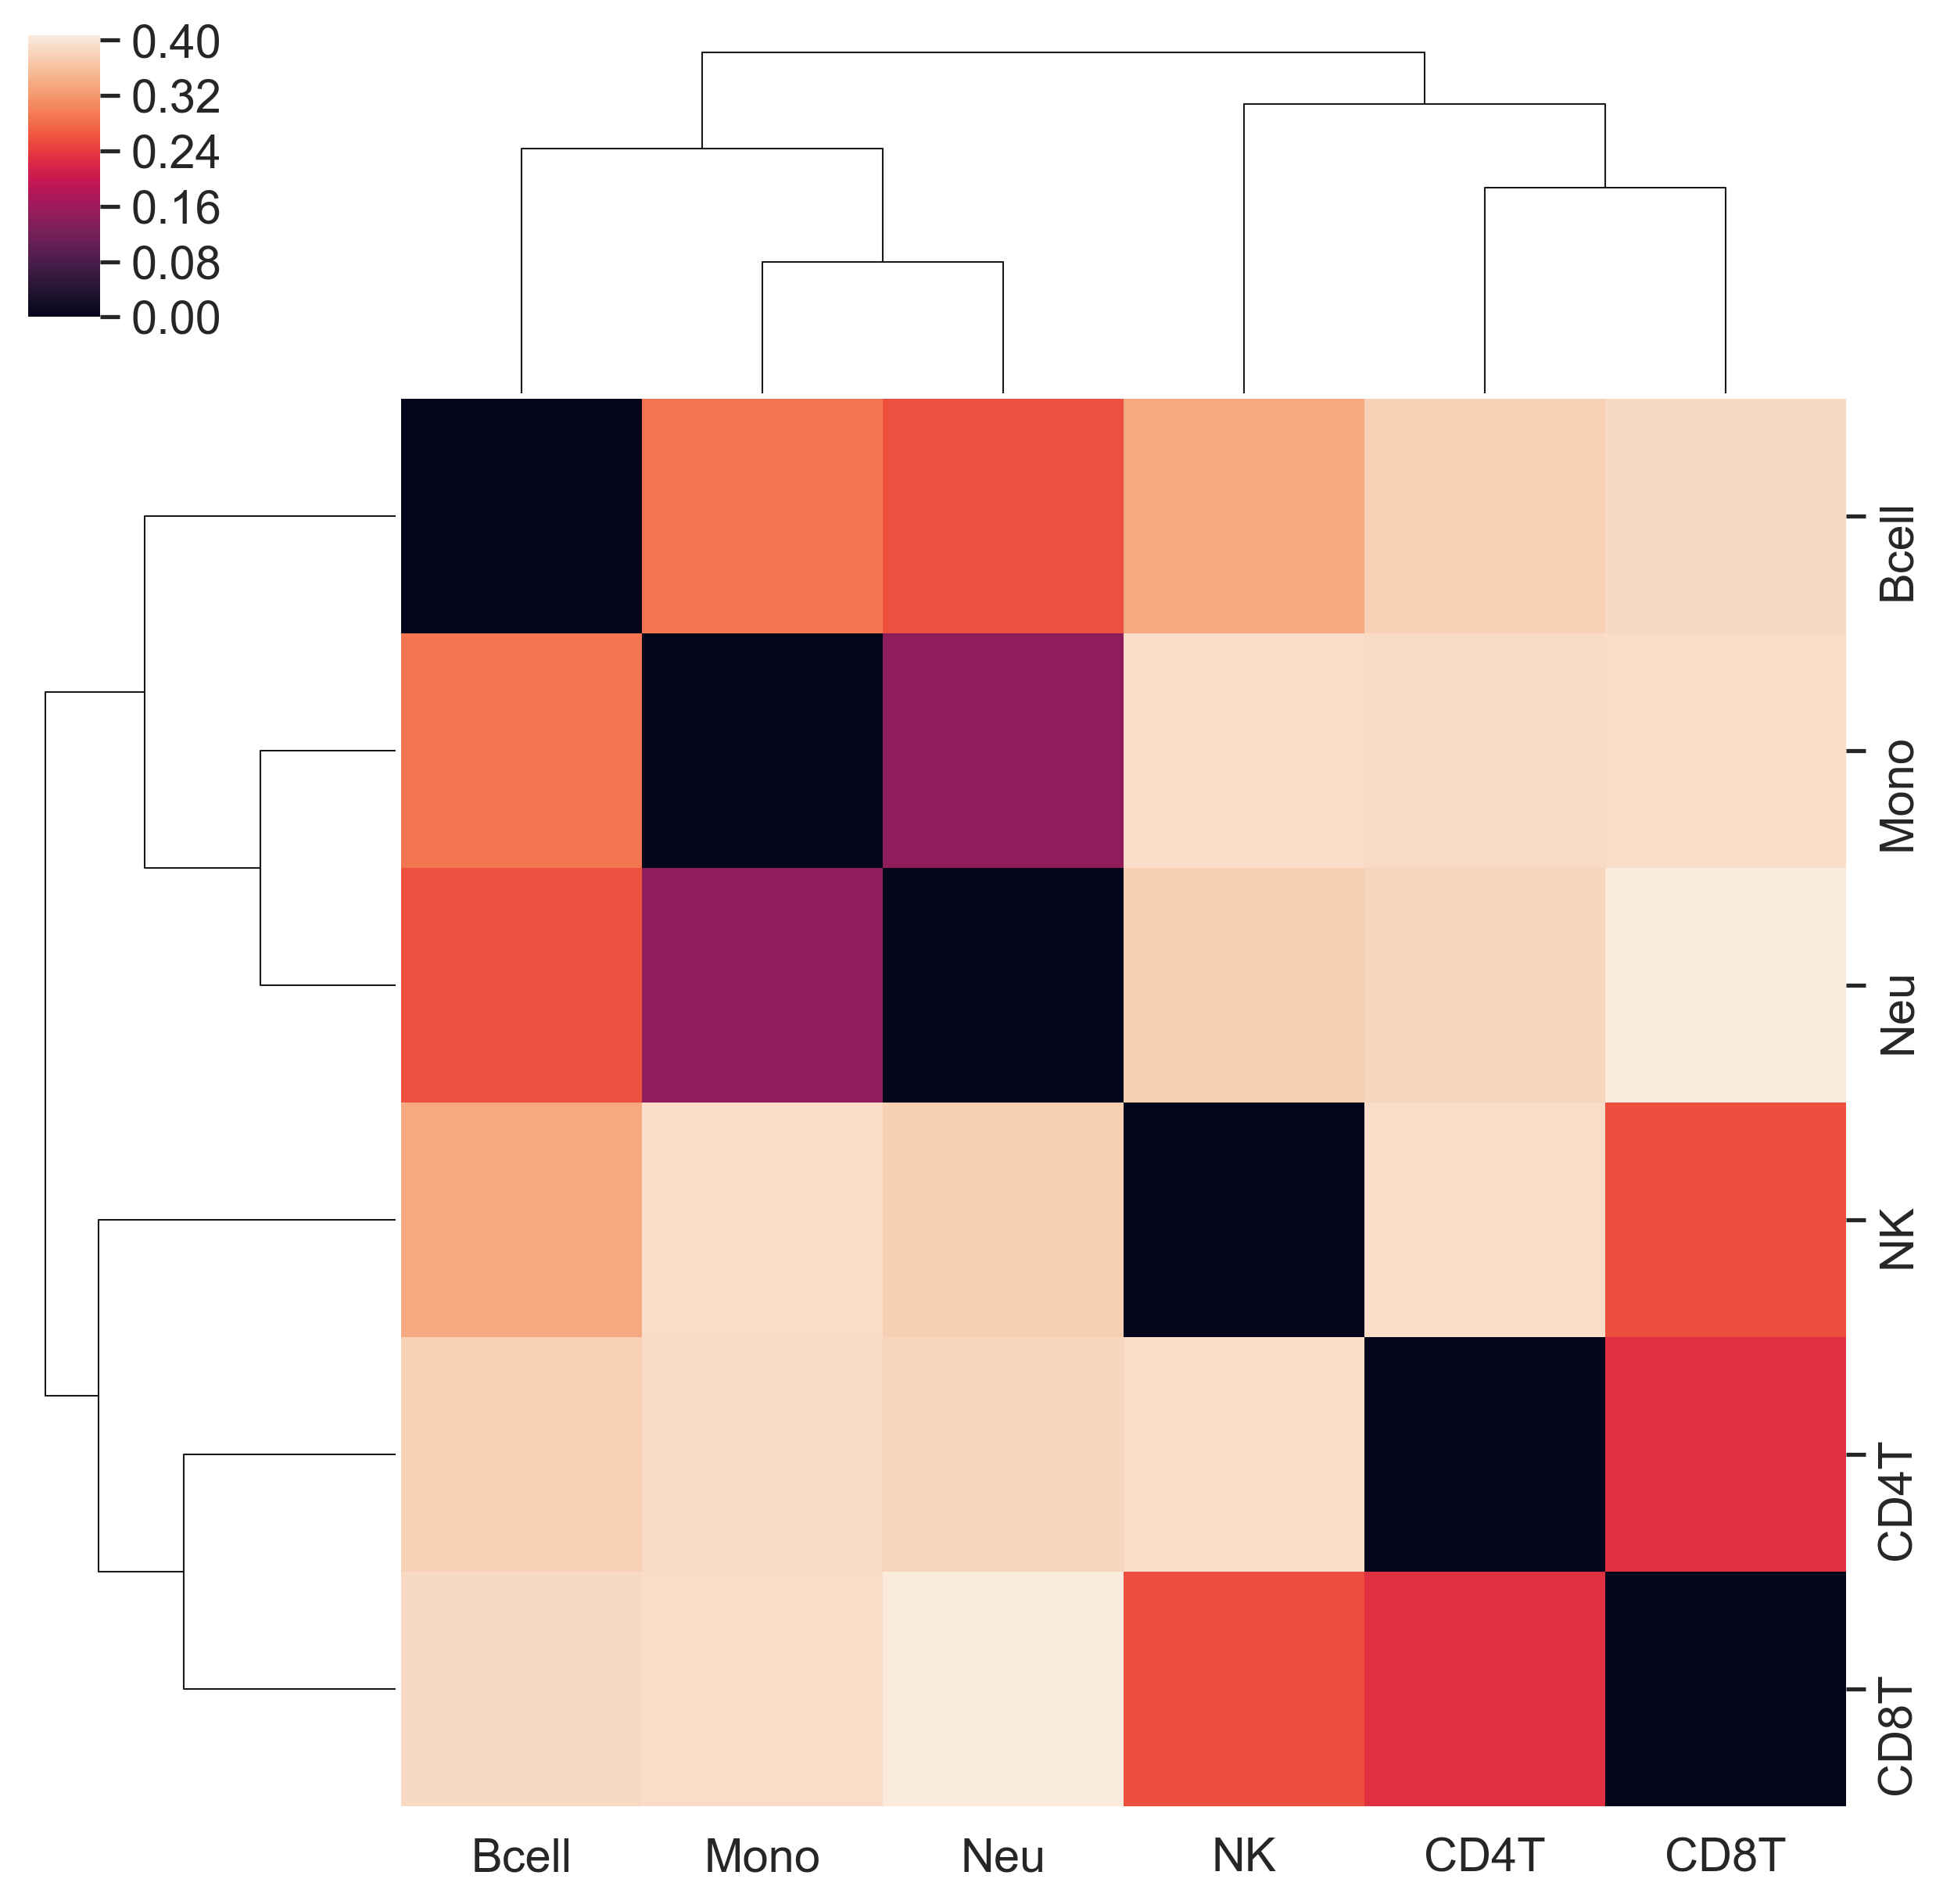

In [88]:
sns.set(font_scale=1.3)
df_cell_corr=pd.read_csv('methylnet_corrections/cell-types/returned_shap_values_corr_dist.csv',index_col=0)
df_cell_corr.index=df_cell_corr.columns=['Bcell','CD4T', 'CD8T', 'Mono', 'NK', 'Neu']
from scipy.cluster.hierarchy import linkage, fcluster
import scipy.spatial as sp

linkage_method='average'
links=linkage(sp.distance.squareform(df_cell_corr.values),method=linkage_method)
sns.clustermap(data=df_cell_corr,row_linkage=links,col_linkage=links)

[['Bcell', '10.54'], ['CD4T', '6.93'], ['CD8T', '3.31'], ['Mono', '7.53'], ['NK', '3.01'], ['Neu', '3.61']]


'Bcell shared cpgs: 29/35.0\nCD4T shared cpgs: 12/23.0\nCD8T shared cpgs: 5/11.0\nMono shared cpgs: 23/25.0\nNK shared cpgs: 9/10.0\nNeu shared cpgs: 2/12.0'

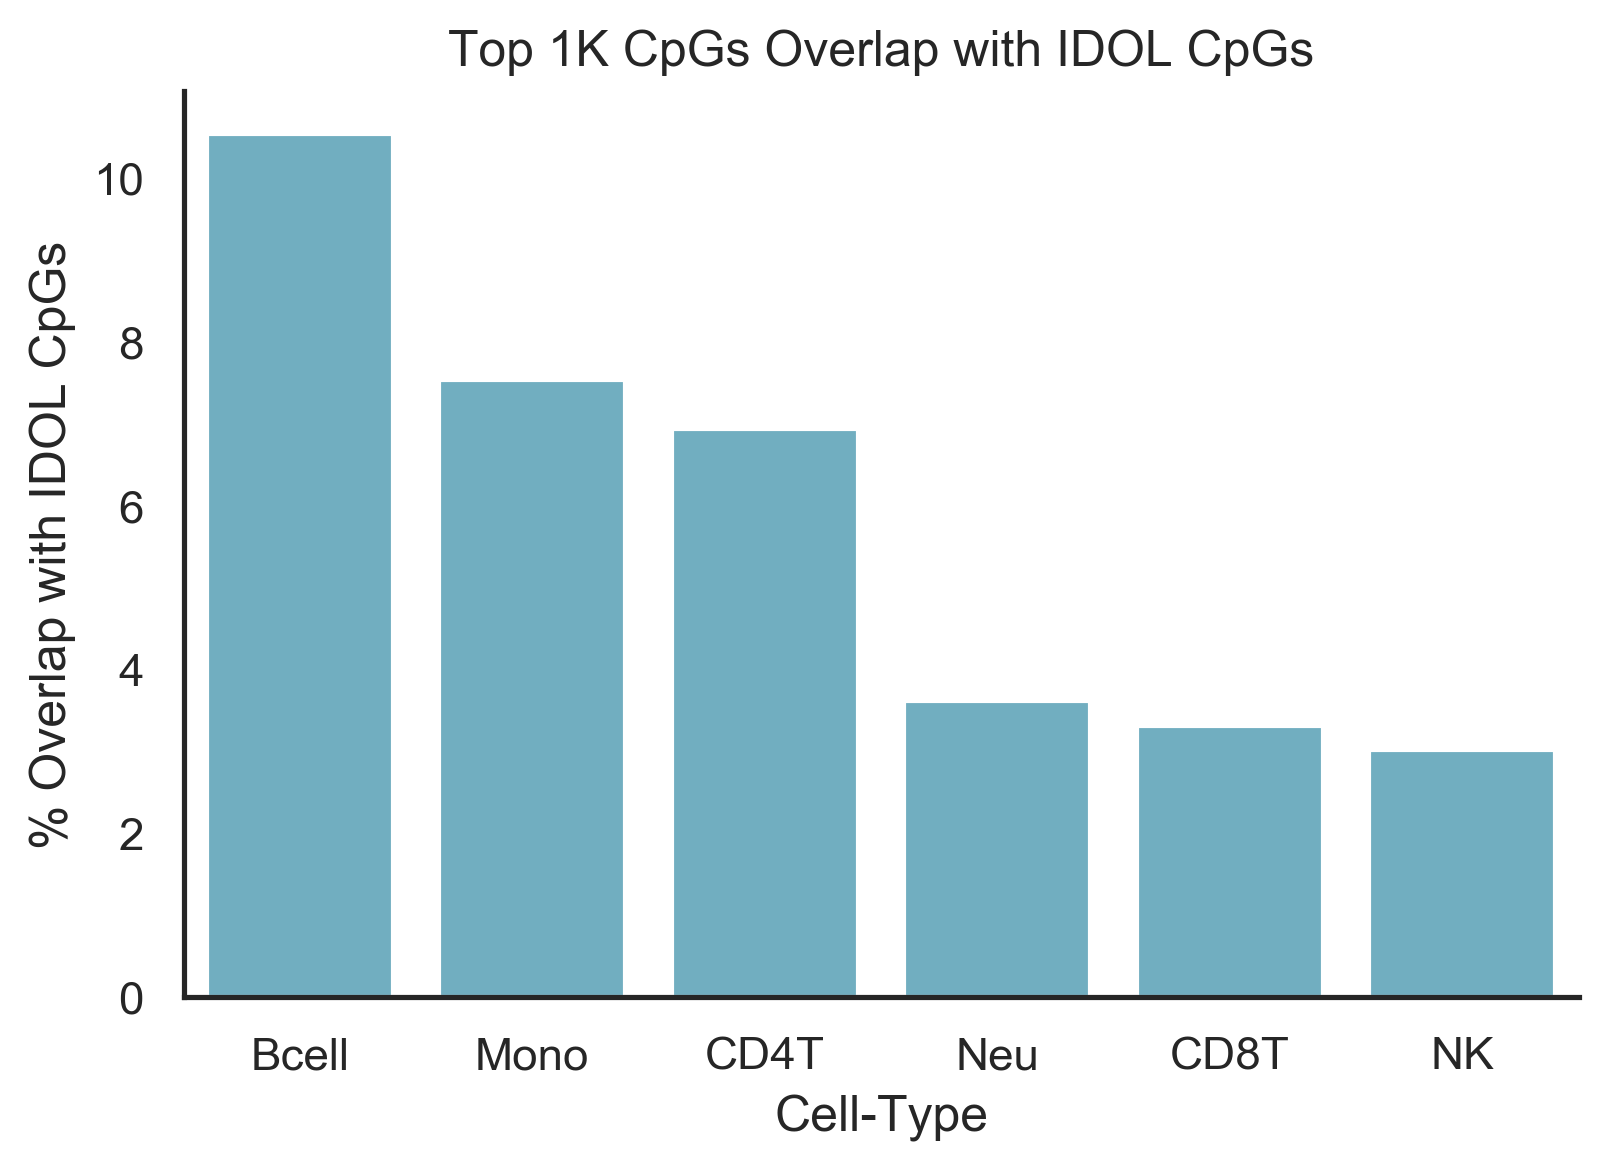

In [90]:
sns.set(style='white',font_scale=1.)
idol_cpg_results = list(map(lambda line: [line.split()[0]]+[w.replace('%','') for w in line.split() if w[-1] in [']','%']],"""Bcell top cpgs overlap with 10.54% of IDOL cpgs
CD4T top cpgs overlap with 6.93% of IDOL cpgs
CD8T top cpgs overlap with 3.31% of IDOL cpgs
Mono top cpgs overlap with 7.53% of IDOL cpgs
NK top cpgs overlap with 3.01% of IDOL cpgs
Neu top cpgs overlap with 3.61% of IDOL cpgs""".splitlines()))
print(idol_cpg_results)
plt.figure()
df=pd.DataFrame(idol_cpg_results,columns=['Cell-Type','Percent IDOL CpGs'])
df.iloc[:,1]=df.iloc[:,1].astype(float)
df=df.iloc[np.argsort(df['Percent IDOL CpGs'])[::-1],:]
sns.barplot('Cell-Type','Percent IDOL CpGs',data=df, color=sns.color_palette()[-1])
plt.ylabel('% Overlap with IDOL CpGs')
plt.title('Top 1K CpGs Overlap with IDOL CpGs')
sns.despine()
"""Bcell shared cpgs: 29/35.0
CD4T shared cpgs: 12/23.0
CD8T shared cpgs: 5/11.0
Mono shared cpgs: 23/25.0
NK shared cpgs: 9/10.0
Neu shared cpgs: 2/12.0"""

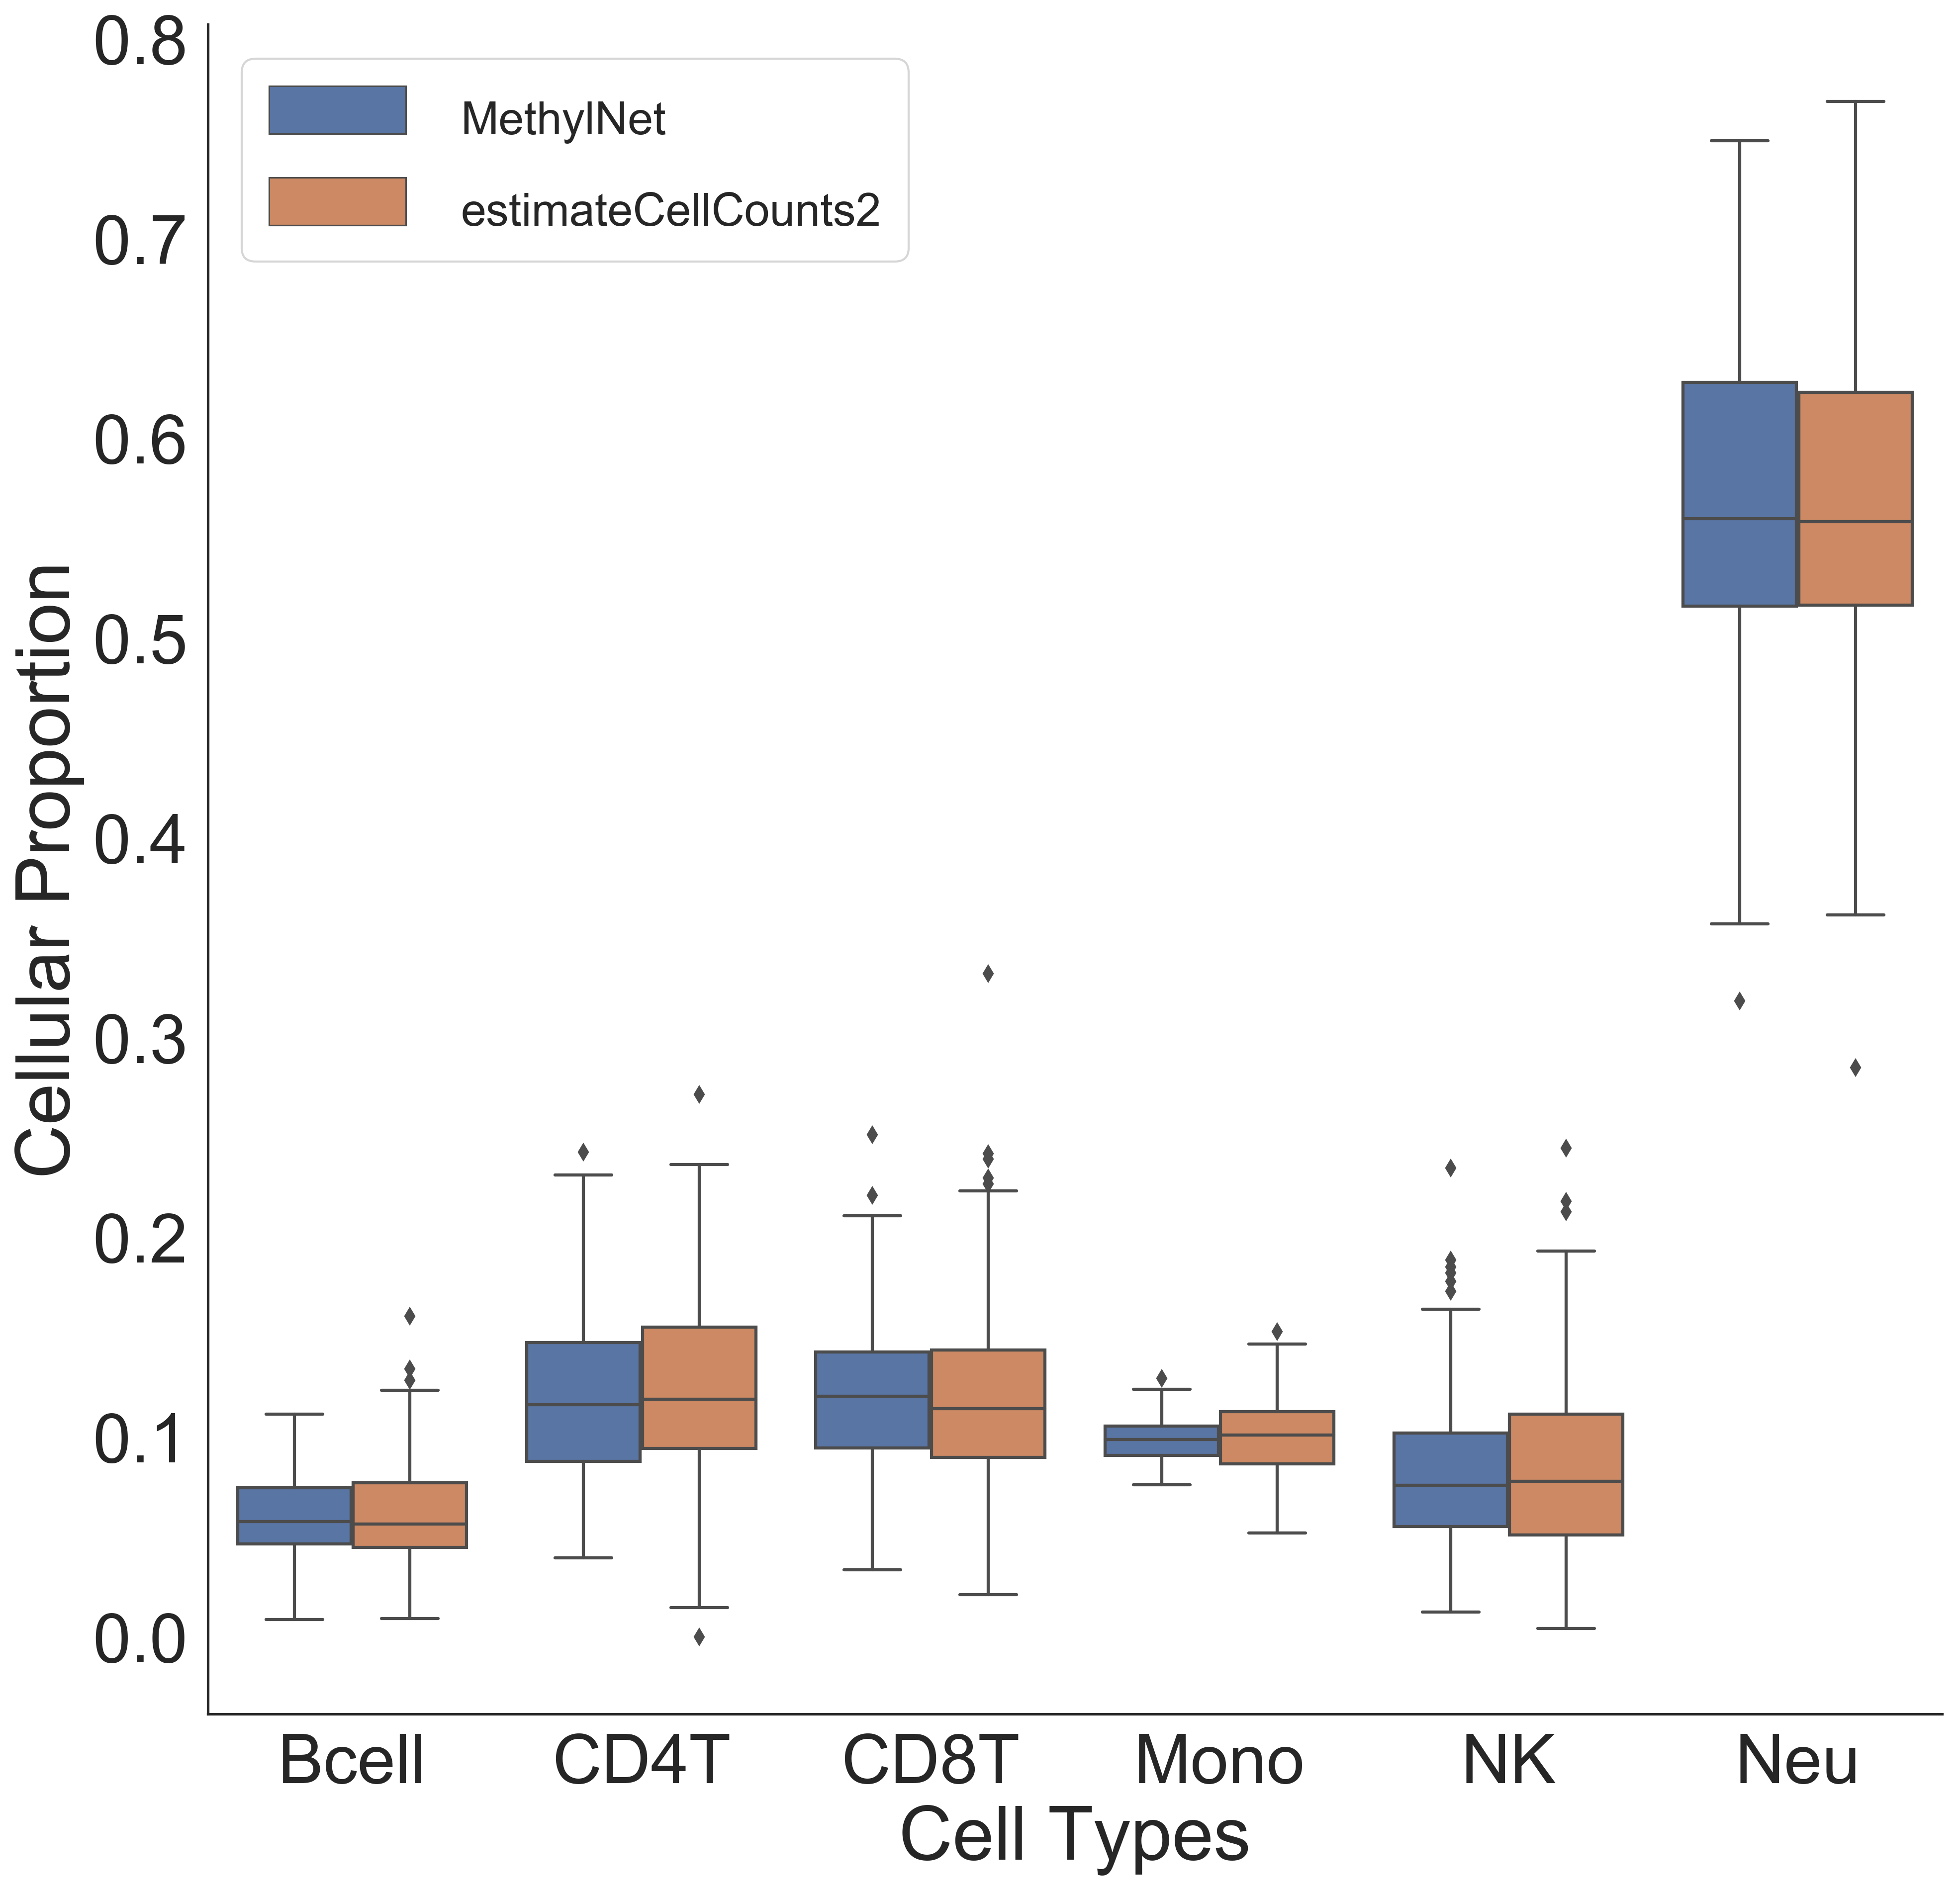

In [9]:
sns.set(style='white',font_scale=3.)

cell_df=dfs['methylnet']['cell']
cell_pred,cell_true=cell_df.iloc[:,:6],cell_df.iloc[:,6:]
cell_names = [name.split('_')[0] for name in cell_pred.columns]
cell_pred.columns=cell_names
cell_true.columns=cell_names

cell_pred['Results']='MethylNet'
cell_true['Results']='estimateCellCounts2'
cell_df = pd.concat([cell_pred,cell_true])
cell_df2=cell_df.melt(value_vars=cell_names,id_vars='Results')
#print(cell_df)
cell_df2=cell_df2.rename(columns={'Results':''})

plt.figure(figsize=(15,15))
ax=sns.boxplot(data=cell_df2,x='variable',y='value',hue='')
plt.setp(ax.get_legend().get_texts(), fontsize='22') 
plt.setp(ax.get_legend().get_title(), fontsize='32')
plt.xlabel('Cell Types')
plt.ylabel('Cellular Proportion')
#plt.title('MethylNet Cell-Type Test Results')
sns.despine()

In [14]:

def generate_cell_results():
    for name in cell_names:
        cell_results = dfs['methylnet']['cell'].loc[:,['{}_pred'.format(name),'{}_true'.format(name)]]
        cell_results.columns=['MethylNet Predicted Proportion','estimateCellCounts2']
        cell_results['Cell Type']=name
        yield cell_results
cell_df=pd.concat([result for result in generate_cell_results()],axis=0)

In [48]:
g.fig.get_figwidth()

10.0

Text(0.27, 0.005, 'MethylNet Predicted Proportion')

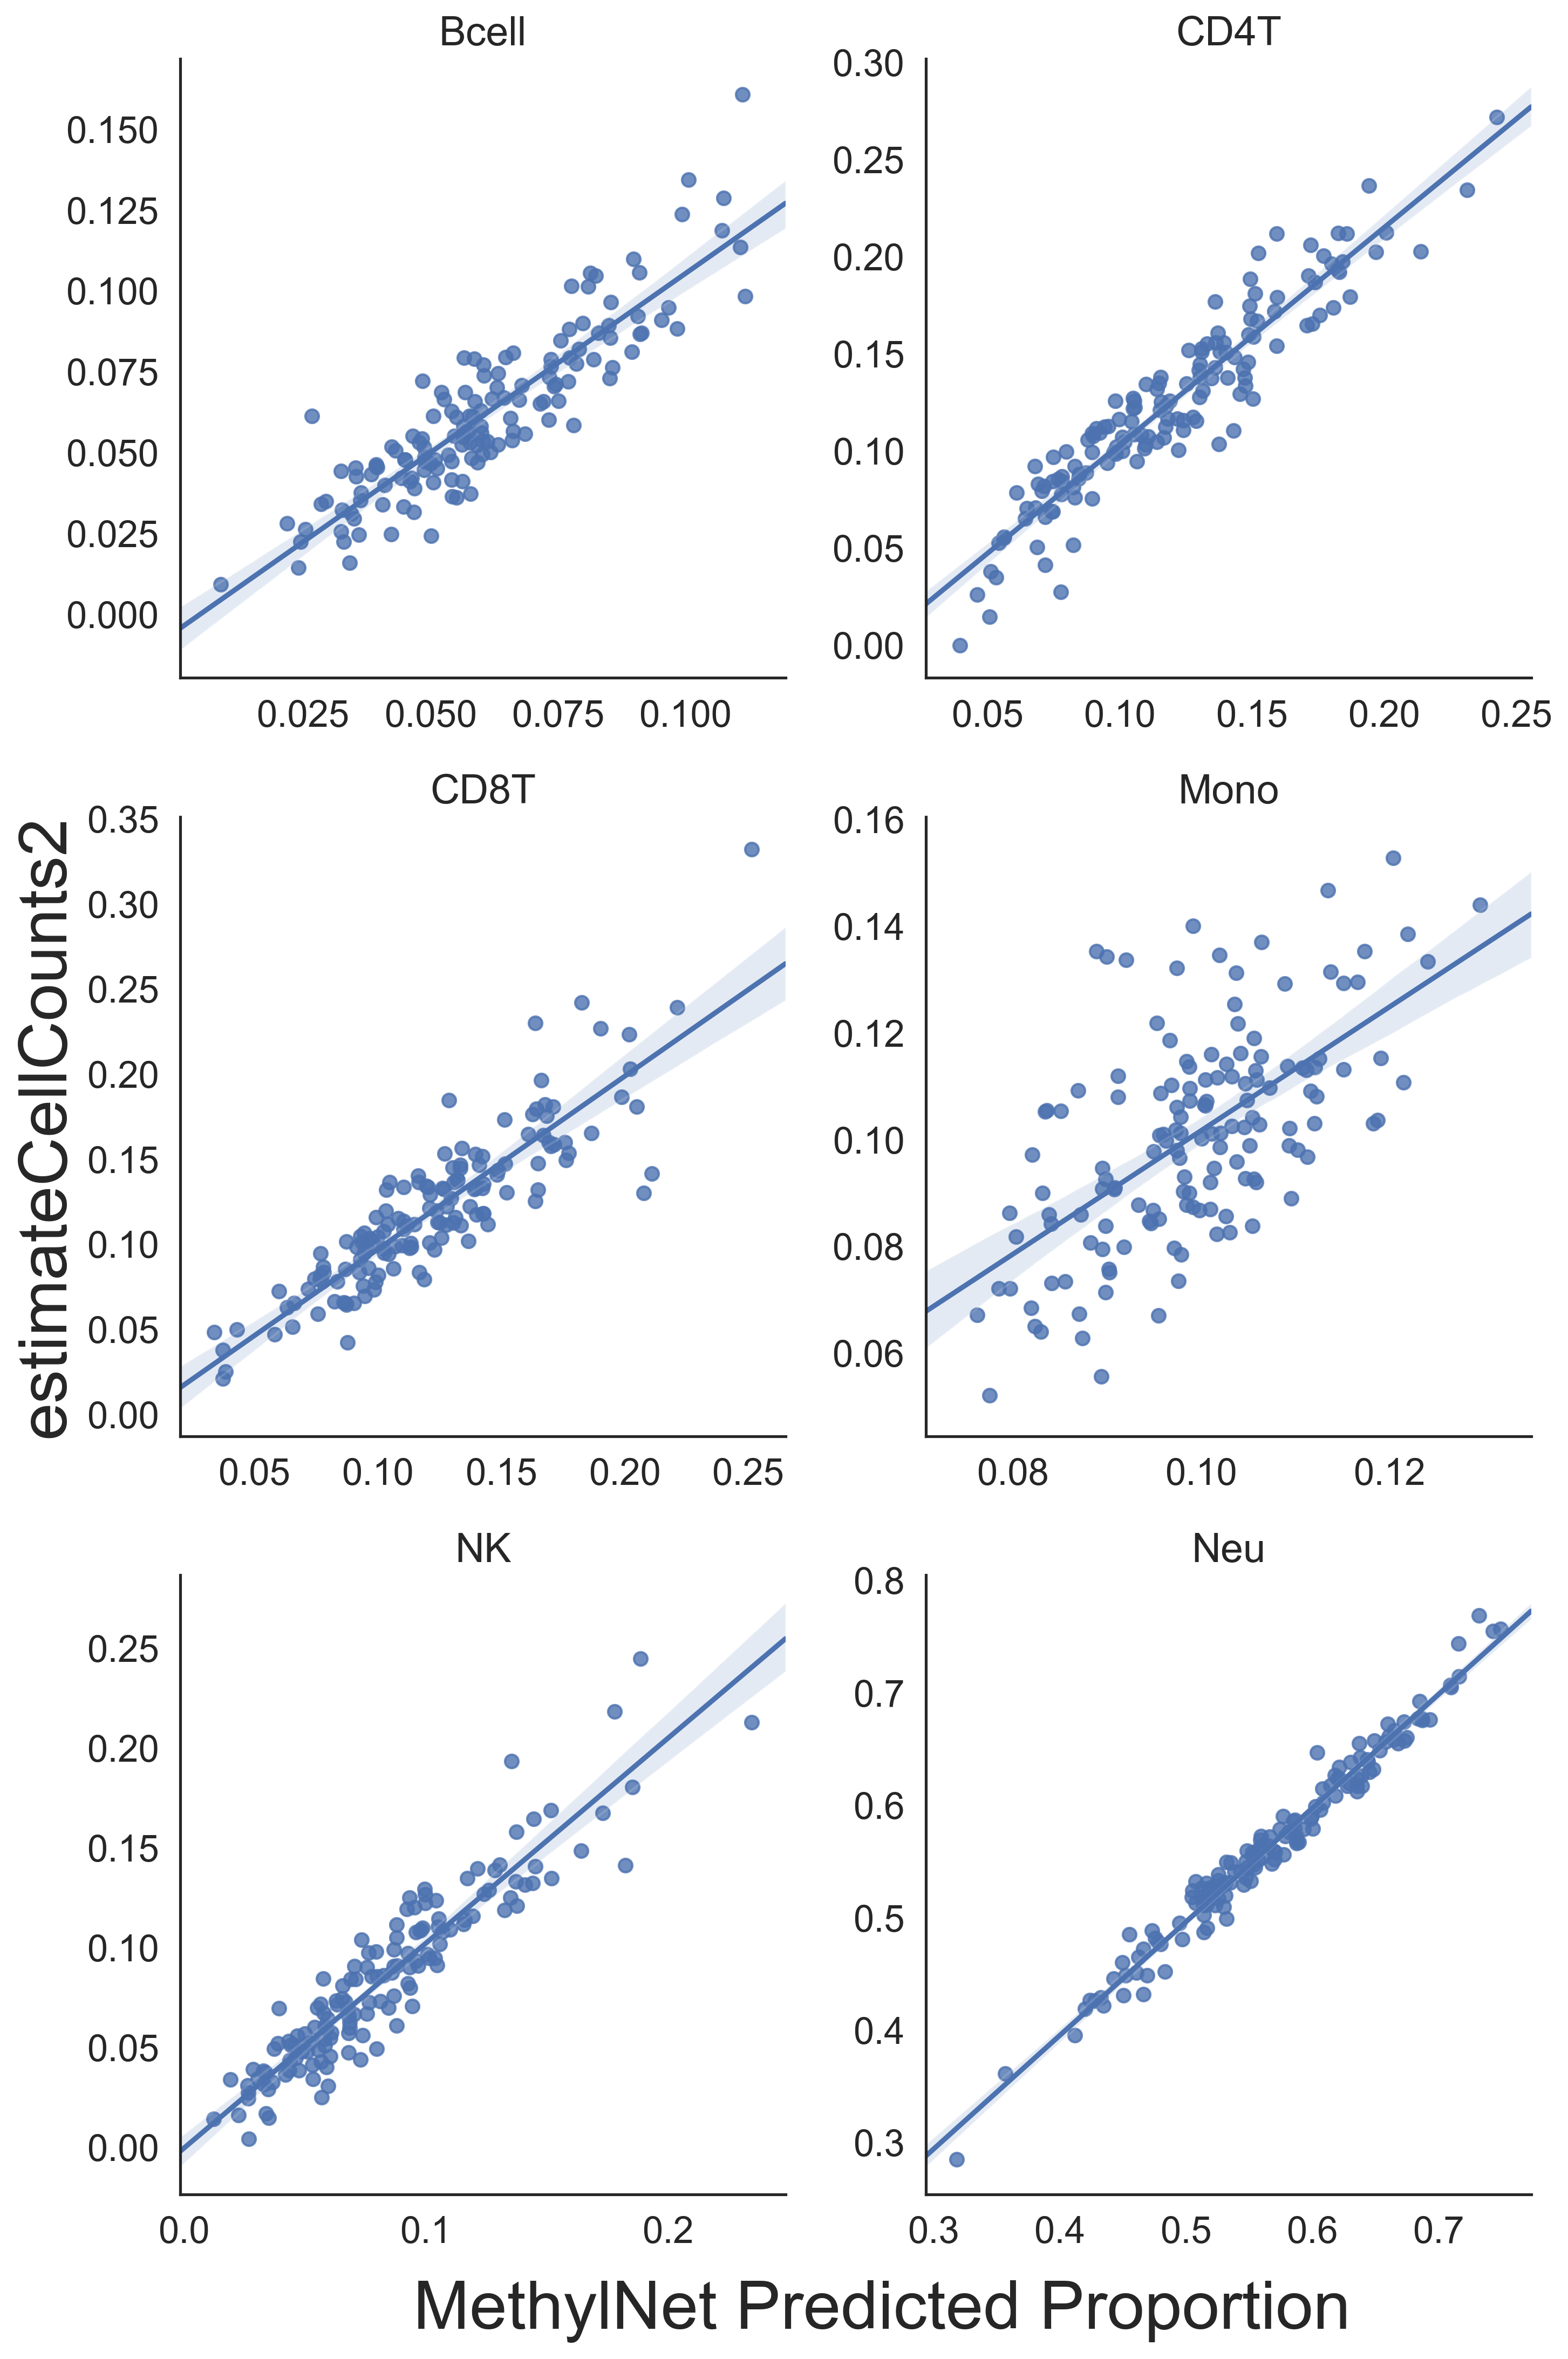

In [15]:
sns.set(style='white',font_scale=1.5)
old=dict(size=15, truncate=True, scatter_kws={"s": 25})
new=dict(col='Cell Type', sharex=False,sharey=False,col_wrap=2,palette=[sns.color_palette()[0]]*6)
g=sns.lmplot('MethylNet Predicted Proportion','estimateCellCounts2',hue='Cell Type',data=cell_df,**new) # 
#sns.lineplot(x=[0,1],y=[0,1],c='black')
plt.subplots_adjust(top=0.94)
#g.fig.suptitle('MethylNet Predicted vs. estimateCellCounts2 Proportions')
axes = g.axes.flatten()
for i,ax in enumerate(axes):
    ax.set_title(cell_names[i])
    ax.set_ylabel('')    
    ax.set_xlabel('')
g.axes[2].set_ylabel('estimateCellCounts2',fontsize=30)
#g.axes[5].set_xlabel('Predicted Proportion',fontsize=30)

g.fig.text(0.27,0.005, 'MethylNet Predicted Proportion', fontsize=30)

           

In [90]:
lb=LabelBinarizer()
dfs['methylnet']['pancancer'].loc[:,'y_true'] = one_hot_encoder.inverse_transform(lb.fit_transform(dfs['methylnet']['pancancer'].loc[:,'y_true']))
dfs['methylnet']['pancancer'].loc[:,'y_pred'] = one_hot_encoder.inverse_transform(lb.transform(dfs['methylnet']['pancancer'].loc[:,'y_pred']))



In [91]:
from functools import reduce

[(0.86, 0.3712, 0.33999999999999997), (0.86, 0.7178666666666667, 0.33999999999999997), (0.6554666666666664, 0.86, 0.33999999999999997), (0.33999999999999997, 0.86, 0.3712), (0.33999999999999997, 0.86, 0.7178666666666667), (0.33999999999999997, 0.6554666666666664, 0.86), (0.3712, 0.33999999999999997, 0.86), (0.7178666666666661, 0.33999999999999997, 0.86), (0.86, 0.33999999999999997, 0.6554666666666664)]


<Figure size 4500x3000 with 0 Axes>

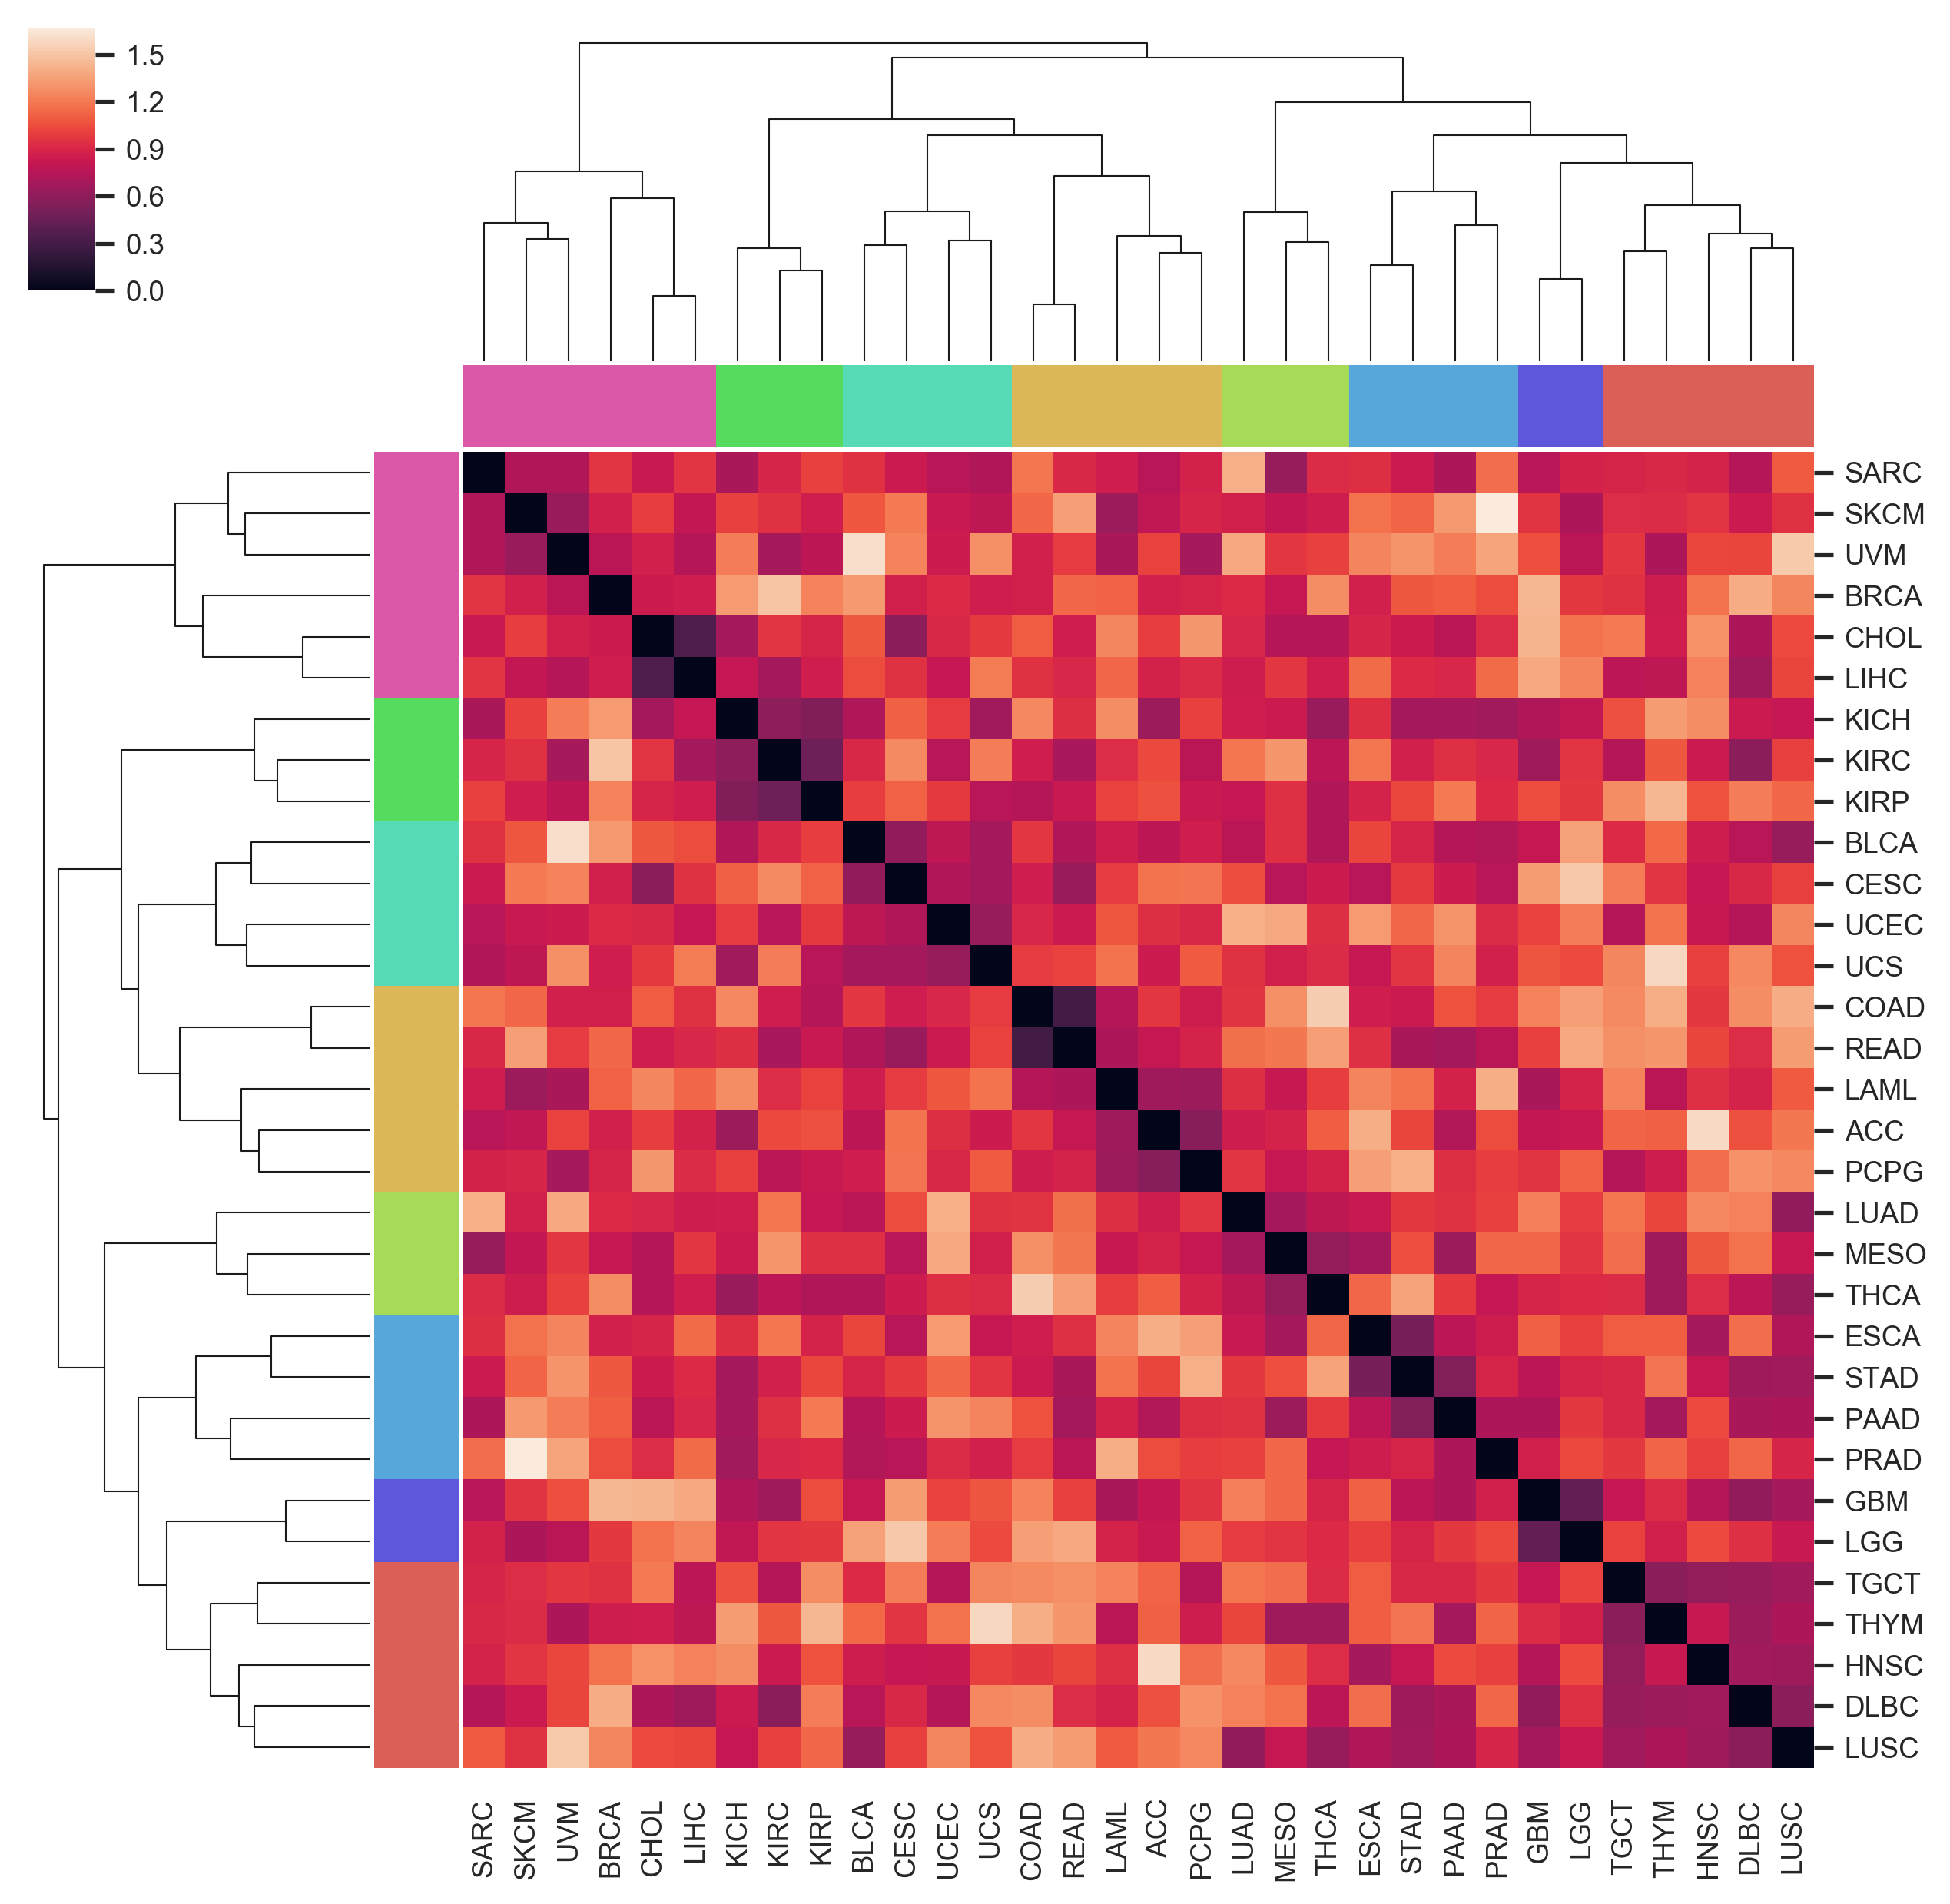

In [133]:
from scipy.cluster.hierarchy import linkage, fcluster
import scipy.spatial as sp
embedding_diff=pd.read_csv('methylnet_corrections/pancancer/class_embedding_differences.csv',index_col=0) # 

linkage_method='complete'
links=linkage(sp.distance.squareform(embedding_diff.values),method=linkage_method)
from sklearn.cluster import AgglomerativeClustering

def col2rgb(col):
    return 'rgb({})'.format(','.join(((np.array(col)*255).astype(int).astype(str).tolist())))
  
cluster = AgglomerativeClustering(n_clusters=8, affinity='precomputed', linkage=linkage_method)
clusters=cluster.fit_predict(embedding_diff.values) 
#clusters=fcluster(links,0.99)
colors=sns.color_palette('hls',max(clusters)+2)
print(colors)
sns.set(font_scale=0.8)
cluster_colors = dict([(subtype,list(colors[int(cluster)-1])) for subtype,cluster in zip(list(embedding_diff.index),list(clusters))])#dict(zip(list(embedding_diff.index),colors))
#clusters=pd.DataFrame(clusters[:,np.newaxis],columns=['Cluster'],index=list(embedding_diff.index)).apply()
plt.figure(figsize=(15,10))
#print(pd.DataFrame.from_dict(cluster_colors,orient='index',columns=['Cluster']))
g=sns.clustermap(embedding_diff,col_linkage=links,row_linkage=links,col_colors=list(cluster_colors.values()),row_colors=list(cluster_colors.values()))#pd.DataFrame.from_dict(cluster_colors,orient='index',columns=['Cluster']))

# np.array(list(cluster_colors.values()))[g.dendrogram_col.reordered_ind]
#plt.xlabel('True Subtype')
#plt.ylabel('Predicted Subtype')
#plt.title('Pancancer Classification Normalized Confusion Matrix')

In [147]:
embedding_diff.iloc[g.dendrogram_row.reordered_ind,g.dendrogram_row.reordered_ind].to_csv('embedding_diff_reordered.csv')

In [112]:
dir(g)
print(g.col_colors)

[(0.33999999999999997, 0.86, 0.7493818181818184), (0.33999999999999997, 0.86, 0.46574545454545463), (0.86, 0.6548363636363637, 0.33999999999999997), (0.33999999999999997, 0.86, 0.46574545454545463), (0.86, 0.6548363636363637, 0.33999999999999997), (0.560290909090909, 0.33999999999999997, 0.86), (0.86, 0.3712, 0.33999999999999997), (0.86, 0.33999999999999997, 0.592436363636363), (0.33999999999999997, 0.6869818181818181, 0.86), (0.86, 0.3712, 0.33999999999999997), (0.4978909090909092, 0.86, 0.33999999999999997), (0.4978909090909092, 0.86, 0.33999999999999997), (0.4978909090909092, 0.86, 0.33999999999999997), (0.33999999999999997, 0.86, 0.7493818181818184), (0.33999999999999997, 0.6869818181818181, 0.86), (0.86, 0.6548363636363637, 0.33999999999999997), (0.7815272727272726, 0.86, 0.33999999999999997), (0.86, 0.3712, 0.33999999999999997), (0.7815272727272726, 0.86, 0.33999999999999997), (0.86, 0.33999999999999997, 0.592436363636363), (0.33999999999999997, 0.86, 0.7493818181818184), (0.86, 

In [63]:
embedding_diff['LUSC']

ACC     1.196319
BLCA    0.631524
BRCA    1.253877
CESC    1.009882
CHOL    1.039315
COAD    1.400750
DLBC    0.592434
ESCA    0.723313
GBM     0.691124
HNSC    0.660331
KICH    0.804634
KIRC    1.000419
KIRP    1.141237
LAML    1.096266
LGG     0.827889
LIHC    1.023172
LUAD    0.608845
LUSC    0.000000
MESO    0.816323
PAAD    0.714417
PCPG    1.259386
PRAD    0.901040
READ    1.337351
SARC    1.097772
SKCM    0.952143
STAD    0.669590
TGCT    0.669071
THCA    0.638164
THYM    0.713168
UCEC    1.254068
UCS     1.065614
UVM     1.524407
Name: LUSC, dtype: float64

In [93]:
clusters_old=["""PAAD
CHOL
LIHC""".splitlines(),
"""COAD
READ
KIRC
KIRP""".splitlines(),
"""LUAD
LUSC
LAML
ESCA
HNSC
DLBC
STAD""".splitlines(),
"""THCA
THYM
KICH
TGCT
UVM""".splitlines(),
"""MESO
ACC
PCPG
PRAD
BLCA
CESC""".splitlines(),
"""LGG
GBM""".splitlines(),
"""UCEC
UCS
SARC
BRCA
SKCM""".splitlines()]


In [143]:
normalize=False
labels=dfs['methylnet']['pancancer'].loc[:,'y_true'].unique()
labels=(embedding_diff.index).values#[np.argsort(clusters)]#list(reduce(lambda x,y: x+y, clusters))
confusion_old=np.array(confusion_matrix(dfs['methylnet']['pancancer'].loc[:,'y_true'],dfs['methylnet']['pancancer'].loc[:,'y_pred'],labels=labels))
if normalize:
    confusion_old=confusion_old.astype('float') / confusion_old.sum(axis=1)[:, np.newaxis]
confusion_old=pd.DataFrame(confusion_old,index=labels,columns=labels).T
confusion=confusion_old.copy().iloc[g.dendrogram_row.reordered_ind,g.dendrogram_row.reordered_ind]
#print(confusion_old)



In [144]:
clusters

array([2, 5, 0, 5, 0, 2, 1, 6, 7, 1, 4, 4, 4, 2, 7, 0, 3, 1, 3, 6, 2, 6,
       2, 0, 0, 6, 1, 3, 1, 5, 5, 0])

In [145]:
if not normalize:
    confusion.to_csv("tables/confusion_new.csv")

In [146]:
if not normalize:
    confusion.to_csv('pancancer-confusion-matrix_new.csv')

<Figure size 4500x3000 with 0 Axes>

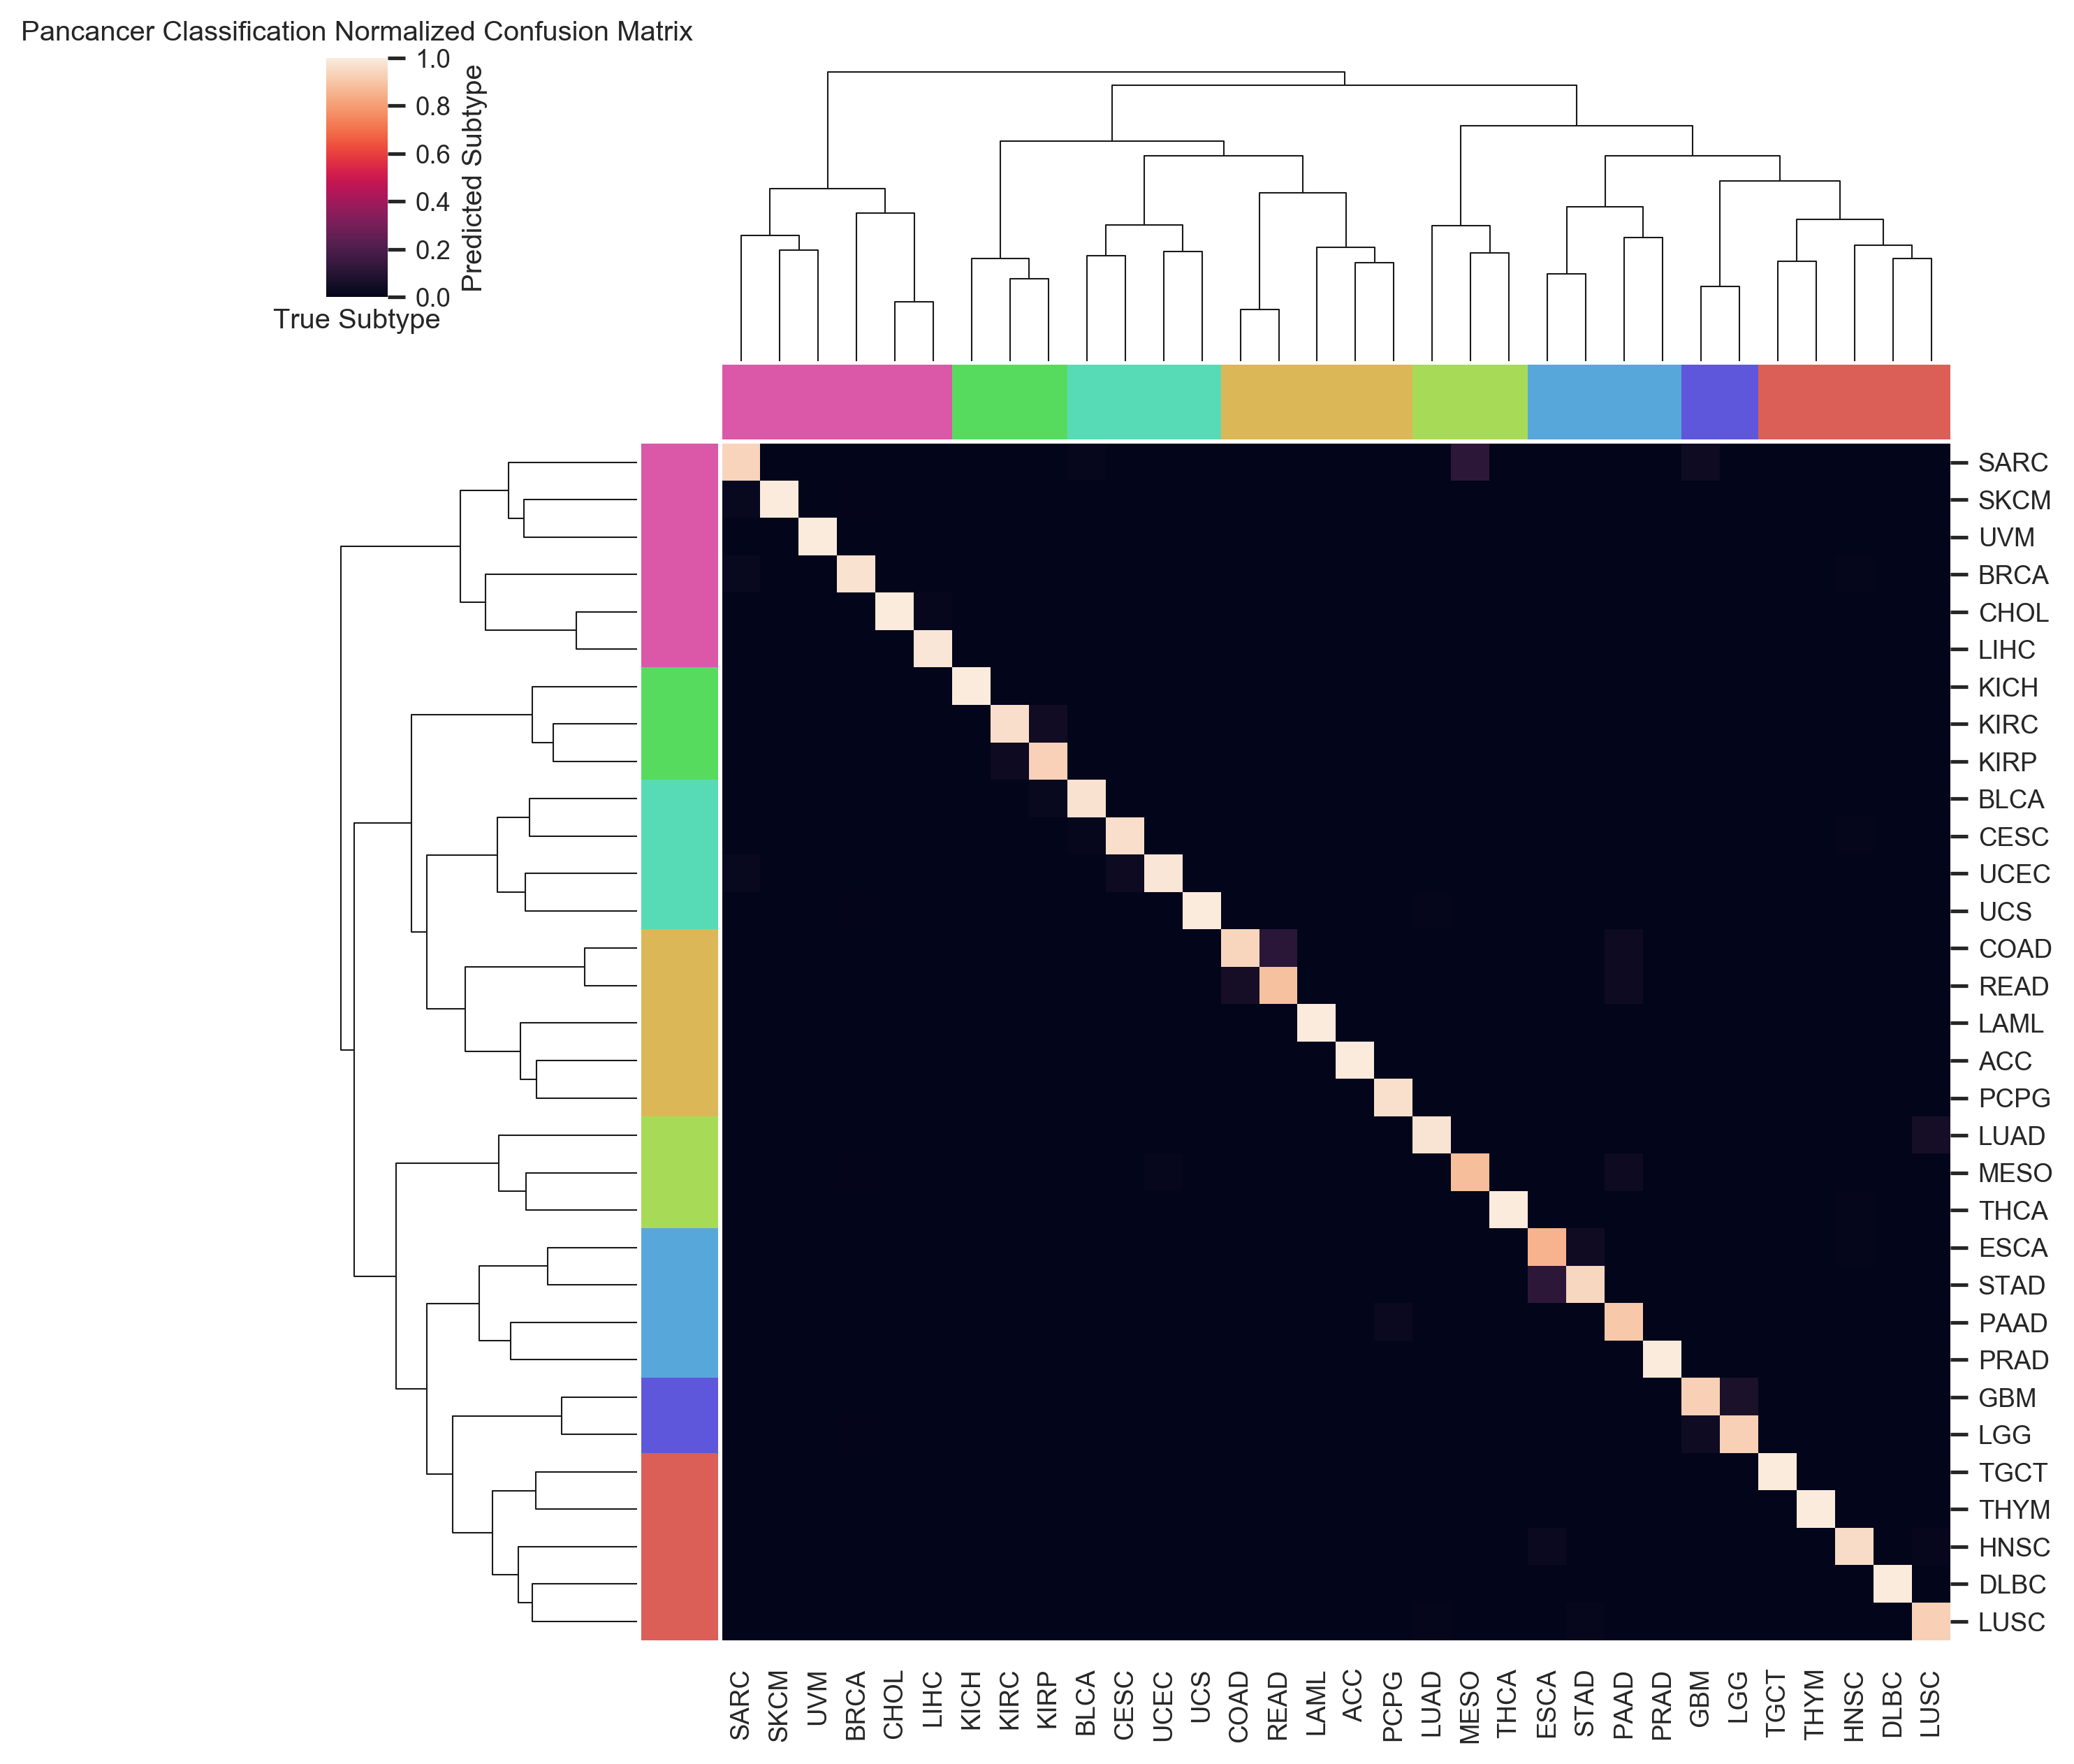

In [140]:
if normalize:
    plt.figure(figsize=(15,10))
    col_clusters=g.col_colors#list(cluster_colors.values())
    sns.clustermap(confusion_old,row_cluster=True,col_cluster=True,col_linkage=links,row_linkage=links,col_colors=col_clusters,row_colors=col_clusters)
    plt.xlabel('True Subtype')
    plt.ylabel('Predicted Subtype')
    plt.title('Pancancer Classification Normalized Confusion Matrix')

In [55]:
embedding_diff=pd.read_csv('class_embedding_differences_p_val.csv',index_col=0)
round(embedding_diff.loc[labels,labels].apply(np.log10),0).fillna('')
#round(embedding_diff.loc[labels,labels],2).to_csv('class_embedding_differences_p-val_reordered.csv')

NameError: name 'labels' is not defined

In [16]:
embedding_diff=pd.read_csv('class_embedding_differences.csv',index_col=0)

round(embedding_diff.loc[labels,labels],2).to_csv('class_embedding_differences_reordered.csv')

In [59]:
average_mechanism='weighted'

def extract_ys(Y):
    return Y[:,0], Y[:,1]

def r2(Y):
    y_true, y_pred=extract_ys(Y)
    return r2_score(y_true, y_pred)

def mae(Y):
    y_true, y_pred=extract_ys(Y)
    return mean_absolute_error(y_true, y_pred)

def explained_variance(Y):
    y_true, y_pred=extract_ys(Y)
    return explained_variance_score(y_true, y_pred)

def accuracy(Y):
    y_true, y_pred=extract_ys(Y)
    return accuracy_score(y_true, y_pred)

def recall(Y):
    y_true, y_pred=extract_ys(Y)
    return recall_score(y_true, y_pred, average=average_mechanism)

def precision(Y):
    y_true, y_pred=extract_ys(Y)
    return precision_score(y_true, y_pred, average=average_mechanism)

def f1(Y):
    y_true, y_pred=extract_ys(Y)
    return f1_score(y_true, y_pred, average=average_mechanism)

In [58]:
scores=[]
for name,dff in dfs['methylnet']['pancancer'].groupby('y_true'):
    Y=dff.loc[:,['y_true','y_pred']].values
    scores.append([accuracy(Y),recall(Y),precision(Y),f1(Y)])

scores=pd.DataFrame(scores,columns=['Accuracy','Recall','Precision','F1'],index=dfs['methylnet']['pancancer']['y_true'].unique()).iloc[g.dendrogram_row.reordered_ind]



AttributeError: 'FacetGrid' object has no attribute 'dendrogram_row'

In [163]:
round(scores,2).to_csv('tables/pancancer_breakdown.csv')

In [60]:
for k1 in dfs:
    for k2 in dfs[k1]:
        print(k1,k2,list(dfs[k1][k2]))
        
print(dfs['other']['cell']['Est_Method'].unique())
classification_fn = {'accuracy':accuracy, 'recall':recall, 'precision':precision, 'f1':f1}
regression_fn = {'r2':r2, 'mae':mae, 'explained_variance':explained_variance}

methylnet pancancer ['y_pred', 'y_true']
methylnet cell ['Bcell_pred', 'CD4T_pred', 'CD8T_pred', 'Mono_pred', 'NK_pred', 'Neu_pred', 'Bcell_true', 'CD4T_true', 'CD8T_true', 'Mono_true', 'NK_true', 'Neu_true']
methylnet age ['Age_pred', 'Age_true']
other pancancer ['y_pred', 'y_true']
other cell ['CD8T', 'CD4T', 'NK', 'Bcell', 'Mono', 'Neu', 'Est_Method']
other age ['Hannum.Est', 'EpiTOC.Est', 'Horvath.Est']
['Robust Partial Correlations' 'Cibersort' 'Constrained Projection']


In [76]:
from numpy import format_float_scientific
def return_bootstrap_results(Y,fn,round_place=1):
    original, std_err, ci_bounds = bootstrap(Y, num_rounds=1000,
                                             func=fn,
                                             ci=0.95,
                                             seed=123)
    #orig_str=#str(round(original,round_place)).split('.')
    #orig_str='.'.join([orig_str[0],orig_str[1][:round_place]])
    std_err=format_float_scientific(std_err,round_place)
    #print(std_err)
    if float(std_err) >= 0.001:
        std_err=float(std_err)
    return "{}±{}".format(float(format_float_scientific(original,round_place)),std_err)

In [55]:
age_res=[]
for k in ['train','val']:
    age_res.append([return_bootstrap_results(pd.DataFrame(np.hstack(all_age_results[k].values()), columns=['y_pred','y_true']).values[:,::-1], regression_fn[fn]) for fn in regression_fn])
    
age_res=pd.DataFrame(age_res,index=['train','val'])
age_res.to_csv('age_train_val_results.csv')
    

NameError: name 'regression_fn' is not defined

In [10]:
age_res

,0,1,2
train,0.993±2.57e-04,1.49±0.0441,0.993±2.45e-04
val,0.973±0.00506,2.69±0.247,0.973±0.00505


In [11]:
cell_res=[]
for i in range(6):
    for k in ['train','val']:
        cell_res.append([return_bootstrap_results(np.vstack((all_cell_results[k]['y_true'][:,i],all_cell_results[k]['y_pred'][:,i])).T, regression_fn[fn]) for fn in regression_fn])
    
cell_res=pd.DataFrame(cell_res)
cell_res.to_csv('cell_train_val_results.csv')



,Predicted Proportion,estimateCellCounts2,Cell Type
GSM2333902_9376538120_R06C01,0.055038,0.036129,Bcell
GSM2333905_9370847096_R06C02,0.066145,0.056656,Bcell
GSM2333914_7766148058_R01C01,0.038332,0.043329,Bcell
GSM2333915_7766148025_R03C02,0.040599,0.033908,Bcell
GSM2333921_7766148058_R03C01,0.079074,0.082003,Bcell
GSM2333922_7766148025_R06C02,0.089799,0.109888,Bcell
GSM2333928_9370847081_R06C02,0.054110,0.047345,Bcell
GSM2333933_9370847011_R04C01,0.056804,0.068667,Bcell
GSM2333935_7766148114_R02C01,0.021857,0.028054,Bcell
GSM2333936_9370847063_R04C02,0.060396,0.077160,Bcell


In [12]:
cell_res

,0,1,2
0,0.884±0.00967,0.00685±2.4e-04,0.89±0.00917
1,0.756±0.0374,0.0101±9.88e-04,0.774±0.0371
2,0.975±0.00218,0.00628±1.79e-04,0.988±0.00102
3,0.874±0.0288,0.0121±0.00115,0.89±0.025
4,0.983±0.00152,0.00476±1.66e-04,0.986±0.00126
5,0.758±0.0469,0.0154±0.00149,0.771±0.0388
6,0.898±0.00947,0.00535±1.76e-04,0.898±0.00941
7,0.385±0.0775,0.0122±0.00138,0.386±0.076
8,0.983±0.00151,0.0055±1.7e-04,0.99±9.69e-04
9,0.819±0.0399,0.0121±0.00136,0.827±0.0373


In [13]:
pancancer_res=[]
for k in ['train','val']:
    pancancer_res.append([return_bootstrap_results(np.vstack((np.argmax(all_pancancer_results[k]['y_true'],axis=1),np.argmax(all_pancancer_results[k]['y_pred'],axis=1))).T, classification_fn[fn]) for fn in classification_fn])
    
pancancer_res=pd.DataFrame(pancancer_res)
pancancer_res.to_csv('pancancer_train_val_results.csv')


In [14]:
pancancer_res

,0,1,2,3
0,1.0±0.e+00,1.0±0.e+00,1.0±0.e+00,1.0±0.e+00
1,0.965±0.00622,0.965±0.00622,0.968±0.00524,0.966±0.00607


In [19]:
all_pancancer_results['val']['y_true'].shape

(840, 32)

In [15]:
cell_types = list(dfs['other']['cell'])[:-1]
results = {'Pancancer':{'MethylNet':[],'UMAP+SVM':[]},
          'Cell-Type Deconvolution':{'MethylNet':{k:[] for k in cell_types},'EpiDISH+RPC':{k:[] for k in cell_types},'EpiDISH+Cibersort':{k:[] for k in cell_types},'EpiDISH+CP':{k:[] for k in cell_types}},
          'Age Prediction':{'MethylNet':[],'Hannum Clock':[],'Horvath Clock':[]}}



In [16]:
le=LabelEncoder()
dfs['methylnet']['pancancer'].loc[:,'y_true'] = le.fit_transform(dfs['methylnet']['pancancer'].loc[:,'y_true'])
dfs['methylnet']['pancancer'].loc[:,'y_pred'] = le.transform(dfs['methylnet']['pancancer'].loc[:,'y_pred'])


In [17]:
results['Pancancer']['MethylNet']={fn:return_bootstrap_results(dfs['methylnet']['pancancer'].iloc[:,::-1].values,classification_fn[fn]) for fn in classification_fn.keys()}

In [18]:
le=LabelEncoder()
dfs['other']['pancancer'].loc[:,'y_true'] = le.fit_transform(dfs['other']['pancancer'].loc[:,'y_true'])
dfs['other']['pancancer'].loc[:,'y_pred'] = le.transform(dfs['other']['pancancer'].loc[:,'y_pred'])

In [19]:
results['Pancancer']['UMAP+SVM']={fn:return_bootstrap_results(dfs['other']['pancancer'].iloc[:,::-1].values,classification_fn[fn]) for fn in classification_fn.keys()}



In [81]:
cell_types = list(dfs['other']['cell'])[:-1]
analysis_dict = {'Robust Partial Correlations':'RPC', 'Cibersort':'Cibersort', 'Constrained Projection':'CP'}
new_cell_results = {k:{'MethylNet':[],'EpiDISH+RPC':[],'EpiDISH+Cibersort':[],'EpiDISH+CP':[]} for k in cell_types}
for cell in cell_types:
    new_cell_results[cell]['MethylNet']={fn:return_bootstrap_results(dfs['methylnet']['cell'][[col for col in list(dfs['methylnet']['cell']) if col.startswith(cell)]].iloc[:,::-1].values,regression_fn[fn]) for fn in regression_fn.keys()}
for name,dff in dfs['other']['cell'].groupby('Est_Method'):
    for cell in cell_types:
        Y=pd.concat([pd.DataFrame(dfs['methylnet']['cell']['{}_true'.format(cell)]),pd.DataFrame(dff[cell])],axis=1).values
        new_cell_results[cell]['EpiDISH+{}'.format(analysis_dict[name])]={fn:return_bootstrap_results(Y,regression_fn[fn]) for fn in regression_fn.keys()}
        


In [82]:
res=[]
for k in ['MethylNet']+['EpiDISH+'+ x for x in analysis_dict.values()]:
    for cell in cell_types:
        res.append(list(new_cell_results[cell][k].values()))

pd.DataFrame(res).set_index(0)

,1,2
0,,
0.78±0.04,0.016±0.0012,0.78±0.038
0.86±0.018,0.014±9.0e-04,0.88±0.016
0.87±0.017,0.012±8.5e-04,0.87±0.017
0.79±0.026,0.009±6.3e-04,0.79±0.025
0.37±0.067,0.012±7.9e-04,0.38±0.062
0.97±0.0043,0.011±7.1e-04,0.97±0.0042
0.72±0.061,0.019±0.0013,0.76±0.052
0.34±0.091,0.036±0.0014,0.89±0.018
0.024±0.11,0.033±0.0024,0.48±0.049


In [ ]:


results_cells = {}

for i,cell in enumerate(cell_types):
    results_cells[cell]=pd.concat([pd.DataFrame(results['Cell-Type Deconvolution'][k][cell],index=[k]) for k in results['Cell-Type Deconvolution']])
    if not i:
        results_cells[cell].columns = pd.MultiIndex.from_product([['Cell-Type Deconvolution'],[cell],results_cells[cell].columns])
    else:
        results_cells[cell].columns = pd.MultiIndex.from_product([[cell],results_cells[cell].columns])

In [20]:
for cell in cell_types:
    results['Cell-Type Deconvolution']['MethylNet'][cell]={fn:return_bootstrap_results(dfs['methylnet']['cell'][[col for col in list(dfs['methylnet']['cell']) if col.startswith(cell)]].iloc[:,::-1].values,regression_fn[fn]) for fn in regression_fn.keys()}
 


In [21]:
for name,dff in dfs['other']['cell'].groupby('Est_Method'):
    for cell in cell_types:
        Y=pd.concat([pd.DataFrame(dfs['methylnet']['cell']['{}_true'.format(cell)]),pd.DataFrame(dff[cell])],axis=1).values
        results['Cell-Type Deconvolution']['EpiDISH+{}'.format(analysis_dict[name])][cell]={fn:return_bootstrap_results(Y,regression_fn[fn]) for fn in regression_fn.keys()}
        
        
        

In [22]:
results['Age Prediction']['MethylNet']={fn:return_bootstrap_results(dfs['methylnet']['age'].iloc[:,::-1].values,regression_fn[fn]) for fn in regression_fn.keys()}
for clock in ['Hannum','Horvath']:
    results['Age Prediction']['{} Clock'.format(clock)]={fn:return_bootstrap_results(pd.concat([pd.DataFrame(dfs['methylnet']['age']['Age_true']),pd.DataFrame(dfs['other']['age']['{}.Est'.format(clock)])],axis=1).values,regression_fn[fn]) for fn in regression_fn.keys()}
    


In [23]:
results

{'Pancancer': {'MethylNet': {'accuracy': '0.965±0.00449',
   'recall': '0.965±0.00449',
   'precision': '0.967±0.00424',
   'f1': '0.966±0.00443'},
  'UMAP+SVM': {'accuracy': '0.839±0.00905',
   'recall': '0.839±0.00905',
   'precision': '0.814±0.0103',
   'f1': '0.823±0.00979'}},
 'Cell-Type Deconvolution': {'MethylNet': {'CD8T': {'r2': '0.778±0.0402',
    'mae': '0.0161±0.0012',
    'explained_variance': '0.781±0.0378'},
   'CD4T': {'r2': '0.864±0.0177',
    'mae': '0.0141±9.02e-04',
    'explained_variance': '0.876±0.0164'},
   'NK': {'r2': '0.868±0.0174',
    'mae': '0.0122±8.51e-04',
    'explained_variance': '0.869±0.0169'},
   'Bcell': {'r2': '0.787±0.026',
    'mae': '0.00896±6.27e-04',
    'explained_variance': '0.789±0.0253'},
   'Mono': {'r2': '0.373±0.0669',
    'mae': '0.0124±7.94e-04',
    'explained_variance': '0.379±0.0622'},
   'Neu': {'r2': '0.972±0.00428',
    'mae': '0.0107±7.1e-04',
    'explained_variance': '0.974±0.00417'}},
  'EpiDISH+RPC': {'CD8T': {'r2': '0.71

{'r2': '0.9642±0.0062',
 'mae': '3.0087±0.2282',
 'explained_variance': '0.9642±0.0062'}

In [24]:
df_pancancer=pd.concat([pd.DataFrame(results['Pancancer'][k],index=[k]) for k in results['Pancancer']])# results['Pancancer']['MethylNet'] = 
df_pancancer.columns = pd.MultiIndex.from_product([['Pancancer'],df_pancancer.columns])
df_pancancer


Pancancer                                             
                accuracy         recall      precision             f1
MethylNet  0.965±0.00449  0.965±0.00449  0.967±0.00424  0.966±0.00443
UMAP+SVM   0.839±0.00905  0.839±0.00905   0.814±0.0103  0.823±0.00979

In [25]:
df_age=pd.concat([pd.DataFrame(results['Age Prediction'][k],index=[k]) for k in results['Age Prediction']])# results['Pancancer']['MethylNet'] = 
df_age.columns = pd.MultiIndex.from_product([['Age Prediction'],df_age.columns])
df_age

Age Prediction                               
                          r2         mae explained_variance
MethylNet      0.964±0.00624  3.01±0.228       0.964±0.0062
Hannum Clock    0.899±0.0128  5.62±0.299      0.953±0.00646
Horvath Clock  0.943±0.00875  3.94±0.269      0.949±0.00784

In [26]:
results_cells = {}

for i,cell in enumerate(cell_types):
    results_cells[cell]=pd.concat([pd.DataFrame(results['Cell-Type Deconvolution'][k][cell],index=[k]) for k in results['Cell-Type Deconvolution']])
    if not i:
        results_cells[cell].columns = pd.MultiIndex.from_product([['Cell-Type Deconvolution'],[cell],results_cells[cell].columns])
    else:
        results_cells[cell].columns = pd.MultiIndex.from_product([[cell],results_cells[cell].columns])




In [27]:
list(results_cells.keys())

['CD8T', 'CD4T', 'NK', 'Bcell', 'Mono', 'Neu']

In [34]:
results_cells[list(results_cells.keys())[5]]

Neu                                   
                              r2             mae explained_variance
MethylNet          0.972±0.00428  0.0107±7.1e-04      0.974±0.00417
EpiDISH+RPC          0.843±0.025   0.029±0.00126      0.961±0.00725
EpiDISH+Cibersort   0.913±0.0147    0.02±0.00113      0.957±0.00796
EpiDISH+CP          0.855±0.0224  0.0289±0.00103      0.976±0.00434

In [35]:
df_pancancer.to_csv("tables/pancancer.csv")
for cell in results_cells:
    results_cells[cell].to_csv("tables/cells_{}.csv".format(cell))

df_age.to_csv("tables/age.csv")

In [239]:
for cell in results_cells:
    print(results_cells[cell].to_latex().replace('±','$\\pm$'))
print(df_age.to_latex().replace('±','$\\pm$'))
print(df_pancancer.to_latex().replace('±','$\\pm$'))

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{Cell-Type Deconvolution} \\
{} & \multicolumn{3}{l}{CD8T} \\
{} &                      r2 &            mae & explained\_variance \\
\midrule
MethylNet         &           0.7776\pm 0.0402 &  0.0161\pm 0.0012 &      0.7807\pm 0.0378 \\
EpiDISH+RPC       &           0.7174\pm 0.0612 &  0.0191\pm 0.0013 &      0.7585\pm 0.0521 \\
EpiDISH+Cibersort &            0.6305\pm 0.077 &  0.0226\pm 0.0014 &      0.7472\pm 0.0546 \\
EpiDISH+CP        &            0.7137\pm 0.067 &  0.0186\pm 0.0014 &      0.7241\pm 0.0635 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{CD4T} \\
{} &              r2 &            mae & explained\_variance \\
\midrule
MethylNet         &   0.8636\pm 0.0177 &  0.0141\pm 0.0009 &      0.8757\pm 0.0164 \\
EpiDISH+RPC       &    0.337\pm 0.0909 &  0.0361\pm 0.0014 &      0.8901\pm 0.0184 \\
EpiDISH+Cibersort &   0.5995\pm 0.0579 &   0.026\pm 0.0014 &      0.8618\pm 0.0203 \\
EpiDISH

In [ ]:
#print(results_cells.to_latex().replace('±','\\pm'))
dfs['methylnet']['pancancer'].shape
dfs['methylnet']['cell'].shape
dfs
import pylatex
pylatex.Tabular(results_cells.to_latex().replace('±','\\pm'))
from tabulate import tabulate
print(tabulate(results_cells))
(
    results_cells
    .pipe(PrettyPandas)
    .style
    .background_gradient()
)#PrettyPandas(results_cells)
from prettypandas import PrettyPandas
results_cells
#results_cells = pd.concat([results_cells[cell] for cell in results_cells],axis=0) # 1
#results_cells.columns = pd.MultiIndex.from_product([['Cell-Type Deconvolution'],results_cells.columns])